In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer, KBinsDiscretizer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# Modelos de Regresión
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor # XGBoost para regresión

# Métricas de Regresión
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import uniform, randint

import warnings
warnings.filterwarnings('ignore') # Ignorar advertencias, útil para la presentación

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 100

# Semilla para reproducibilidad
np.random.seed(42)

print("Librerías cargadas para Regresión.")

# --- 1.1 Generación del Dataset Sintético para Regresión ---
n_samples = 1500

# Variables Numéricas
edad = np.random.randint(18, 90, n_samples)
gravedad_condicion = np.random.randint(1, 11, n_samples) # 1-10
presion_sistolica = np.random.normal(125, 18, n_samples)
temperatura_c = np.random.normal(37.0, 0.8, n_samples)
nivel_dolor = np.random.randint(1, 11, n_samples) # 1-10
num_comorbilidades = np.random.randint(0, 5, n_samples)
respuesta_medicacion_inicial_score = np.random.randint(0, 11, n_samples) # 0-10
estancia_previa_dias = np.random.choice([0, 0, 0, 0, 0, 1, 2, 3, 4, 5], n_samples) # Más ceros, algunos días
frecuencia_cardiaca = np.random.normal(80, 15, n_samples)
nivel_oxigeno_sanguineo = np.random.normal(97, 2, n_samples)
peso_kg = np.random.normal(75, 15, n_samples)
altura_cm = np.random.normal(170, 10, n_samples)
imc = peso_kg / ((altura_cm / 100)**2)


# Inyectar algunos outliers en variables numéricas
presion_sistolica[np.random.choice(n_samples, 15, replace=False)] = np.random.normal(190, 15, 15) # Hipertensión severa
temperatura_c[np.random.choice(n_samples, 10, replace=False)] = np.random.normal(40.5, 0.5, 10) # Fiebre alta
nivel_dolor[np.random.choice(n_samples, 20, replace=False)] = np.random.randint(9, 11, 20) # Dolor muy severo


# Variables Categóricas
genero = np.random.choice(['Masculino', 'Femenino', 'No binario'], n_samples, p=[0.49, 0.49, 0.02])
tipo_admision = np.random.choice(['Urgencia', 'Electiva', 'Transferencia'], n_samples, p=[0.6, 0.3, 0.1])
tipo_seguro = np.random.choice(['Privado', 'Público', 'Sin Seguro'], n_samples, p=[0.4, 0.5, 0.1])
fumador = np.random.choice(['Sí', 'No'], n_samples, p=[0.2, 0.8])
diagnostico_principal = np.random.choice(['Cardio', 'Respiratorio', 'Digestivo', 'Neurologico', 'Infeccioso', 'Ortopedico'], n_samples, p=[0.2, 0.2, 0.15, 0.15, 0.2, 0.1])
unidad_ingreso = np.random.choice(['UCI', 'Sala General', 'Cuidados Intermedios'], n_samples, p=[0.15, 0.70, 0.15])


# Variables de Fecha/Hora
fecha_ingreso_base = pd.to_datetime('2024-01-01')
fecha_ingreso = fecha_ingreso_base + pd.to_timedelta(np.random.randint(0, 365*2, n_samples), unit='D') # Últimos 2 años


# Crear DataFrame
data_reg = pd.DataFrame({
    'ID_Paciente': range(1, n_samples + 1),
    'Edad': edad,
    'Gravedad_Condicion': gravedad_condicion,
    'Presion_Sistolica': presion_sistolica,
    'Temperatura_C': temperatura_c,
    'Nivel_Dolor': nivel_dolor,
    'Num_Comorbilidades': num_comorbilidades,
    'Respuesta_Medicacion_Inicial_Score': respuesta_medicacion_inicial_score,
    'Estancia_Previa_Dias': estancia_previa_dias,
    'Frecuencia_Cardiaca': frecuencia_cardiaca,
    'Nivel_Oxigeno_Sanguineo': nivel_oxigeno_sanguineo,
    'Indice_Masa_Corporal': imc,
    'Genero': genero,
    'Tipo_Admision': tipo_admision,
    'Tipo_Seguro': tipo_seguro,
    'Fumador': fumador,
    'Diagnostico_Principal': diagnostico_principal,
    'Unidad_Ingreso': unidad_ingreso,
    'Fecha_Ingreso': fecha_ingreso
})

# Inyectar valores nulos aleatoriamente (aprox. 3-5% de nulos en algunas columnas)
for col in ['Presion_Sistolica', 'Temperatura_C', 'Indice_Masa_Corporal', 'Tipo_Seguro', 'Fumador', 'Nivel_Oxigeno_Sanguineo']:
    data_reg.loc[np.random.choice(n_samples, int(n_samples * 0.04), replace=False), col] = np.nan

# --- Generación de la Variable Objetivo 'Dias_Hospitalizacion' (Continua) ---
# Días base
dias_hospitalizacion = (
    2 + # Base de 2 días
    data_reg['Gravedad_Condicion'] * 0.8 +
    data_reg['Edad'] * 0.05 +
    data_reg['Num_Comorbilidades'] * 1.5 +
    (data_reg['Presion_Sistolica'] > 140) * 1.0 +
    (data_reg['Temperatura_C'] > 38.0) * 1.0 +
    (data_reg['Nivel_Dolor'] > 7) * 0.5 +
    (data_reg['Respuesta_Medicacion_Inicial_Score'] < 5) * 1.5 + # Mala respuesta = más días
    data_reg['Estancia_Previa_Dias'] * 0.5 # Estancias previas pueden indicar mayor complejidad
)

# Ajustar por tipo de admisión
dias_hospitalizacion[data_reg['Tipo_Admision'] == 'Urgencia'] += 1.5
dias_hospitalizacion[data_reg['Tipo_Admision'] == 'UCI'] += 3.0 # Pacientes de UCI más días
dias_hospitalizacion[data_reg['Unidad_Ingreso'] == 'UCI'] += 3.0 # Mayor impacto si entra a UCI

# Ajustar por diagnóstico principal
dias_hospitalizacion[data_reg['Diagnostico_Principal'] == 'Cardio'] += 1.0
dias_hospitalizacion[data_reg['Diagnostico_Principal'] == 'Respiratorio'] += 1.5
dias_hospitalizacion[data_reg['Diagnostico_Principal'] == 'Neurologico'] += 2.0
dias_hospitalizacion[data_reg['Diagnostico_Principal'] == 'Infeccioso'] += 1.0


# Añadir ruido aleatorio (normalmente distribuido) y asegurar que no haya días negativos
dias_hospitalizacion = dias_hospitalizacion + np.random.normal(0, 2, n_samples)
dias_hospitalizacion = np.maximum(1, dias_hospitalizacion).round(0) # Mínimo 1 día, redondear a entero

data_reg['Dias_Hospitalizacion'] = dias_hospitalizacion.astype(int)


print(f"Dataset sintético de regresión generado con {data_reg.shape[0]} filas y {data_reg.shape[1]} columnas.")
print("\nPrimeras 5 filas del dataset:")
print(data_reg.head())
print(f"\nEstadísticas de la variable objetivo 'Dias_Hospitalizacion':\n{data_reg['Dias_Hospitalizacion'].describe()}")
print("\nEstado de nulos en el dataset:")
print(data_reg.isnull().sum()[data_reg.isnull().sum() > 0])

Librerías cargadas para Regresión.
Dataset sintético de regresión generado con 1500 filas y 20 columnas.

Primeras 5 filas del dataset:
   ID_Paciente  Edad  Gravedad_Condicion  Presion_Sistolica  Temperatura_C  \
0            1    69                   3         123.081294      37.127102   
1            2    32                  10         142.192774      36.706184   
2            3    89                   3         162.986379      37.776157   
3            4    78                   7         103.966202      36.036052   
4            5    38                   4         148.053220      37.918031   

   Nivel_Dolor  Num_Comorbilidades  Respuesta_Medicacion_Inicial_Score  \
0            2                   1                                   0   
1            1                   3                                   9   
2            1                   1                                   7   
3            4                   3                                   0   
4            6           


--- 2.1 Información General del Dataset de Regresión ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 20 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   ID_Paciente                         1500 non-null   int64         
 1   Edad                                1500 non-null   int32         
 2   Gravedad_Condicion                  1500 non-null   int32         
 3   Presion_Sistolica                   1440 non-null   float64       
 4   Temperatura_C                       1440 non-null   float64       
 5   Nivel_Dolor                         1500 non-null   int32         
 6   Num_Comorbilidades                  1500 non-null   int32         
 7   Respuesta_Medicacion_Inicial_Score  1500 non-null   int32         
 8   Estancia_Previa_Dias                1500 non-null   int32         
 9   Frecuencia_Cardiaca                 15

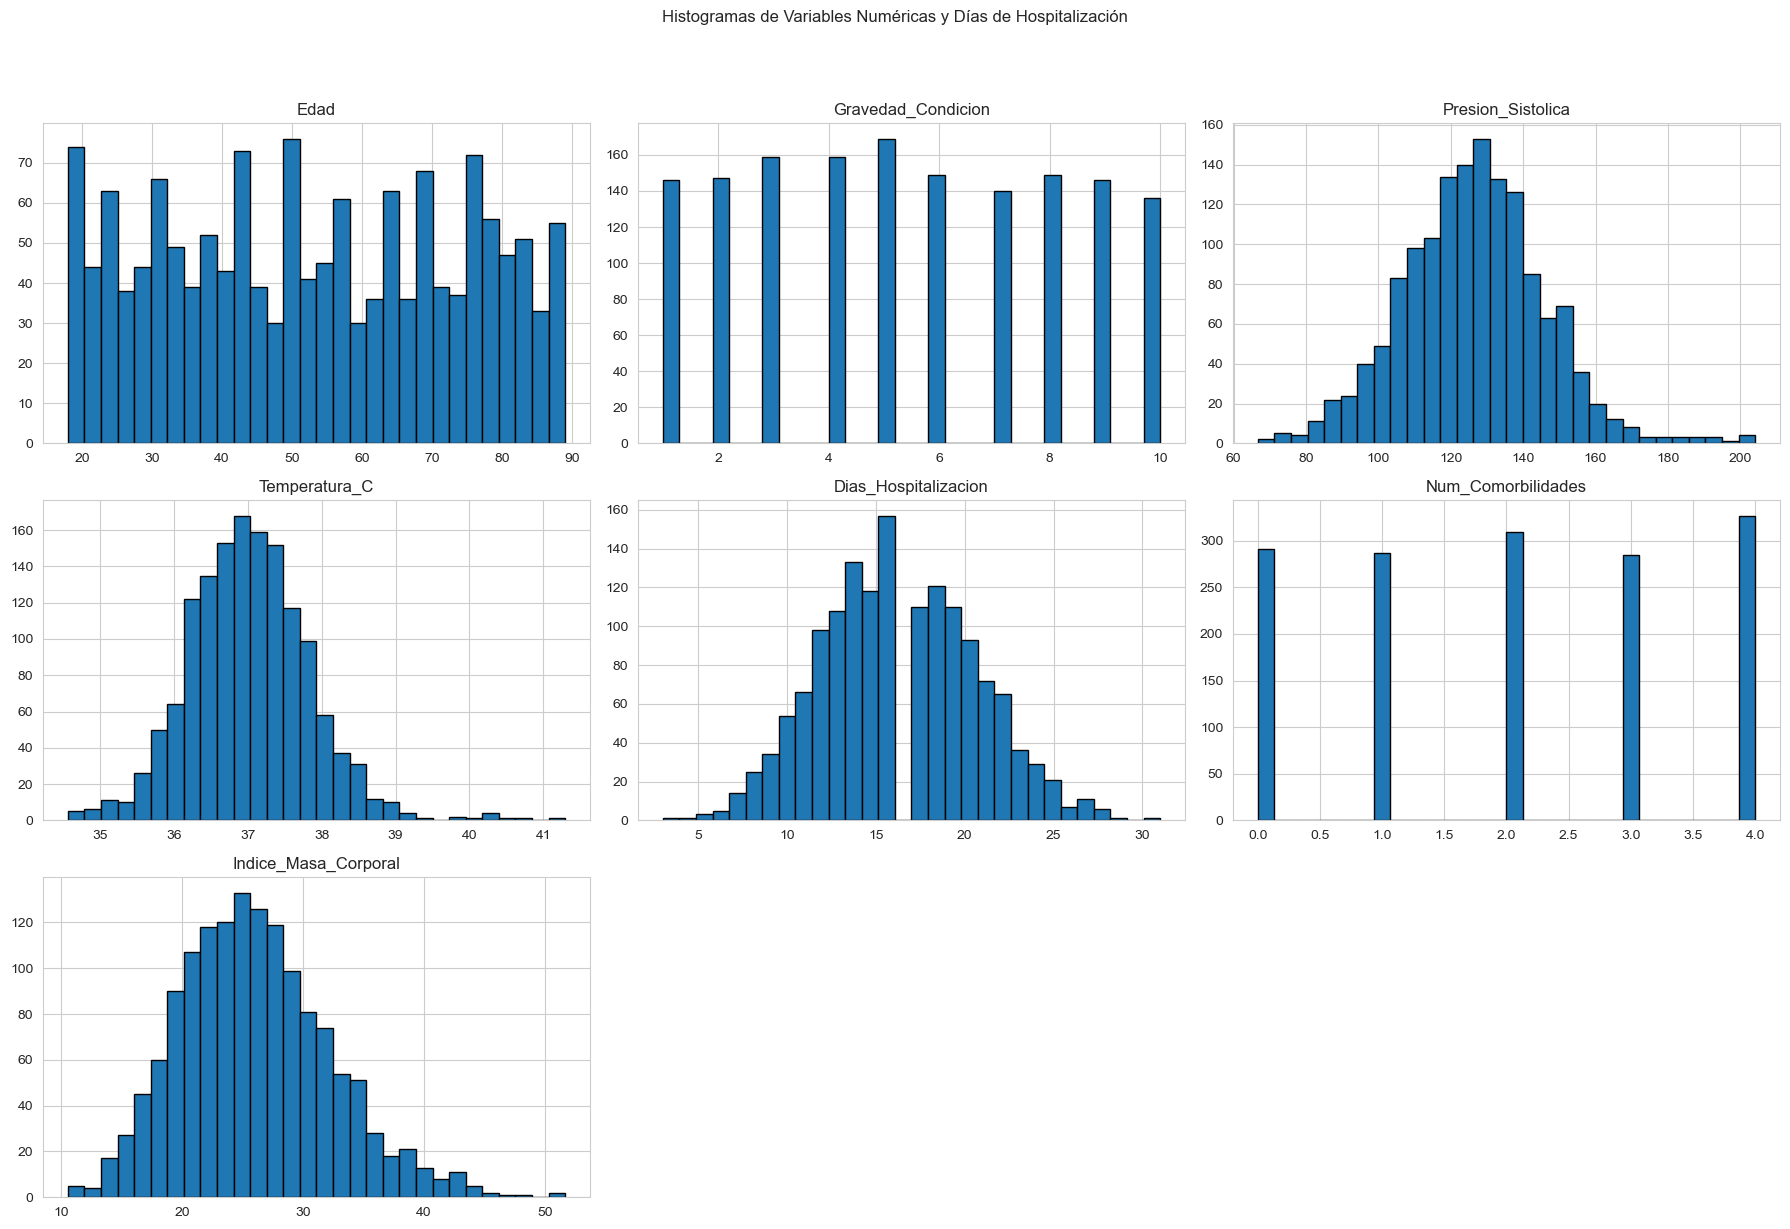


--- 2.4.2 Diagramas de Caja (Box Plots) para Identificar Outliers ---


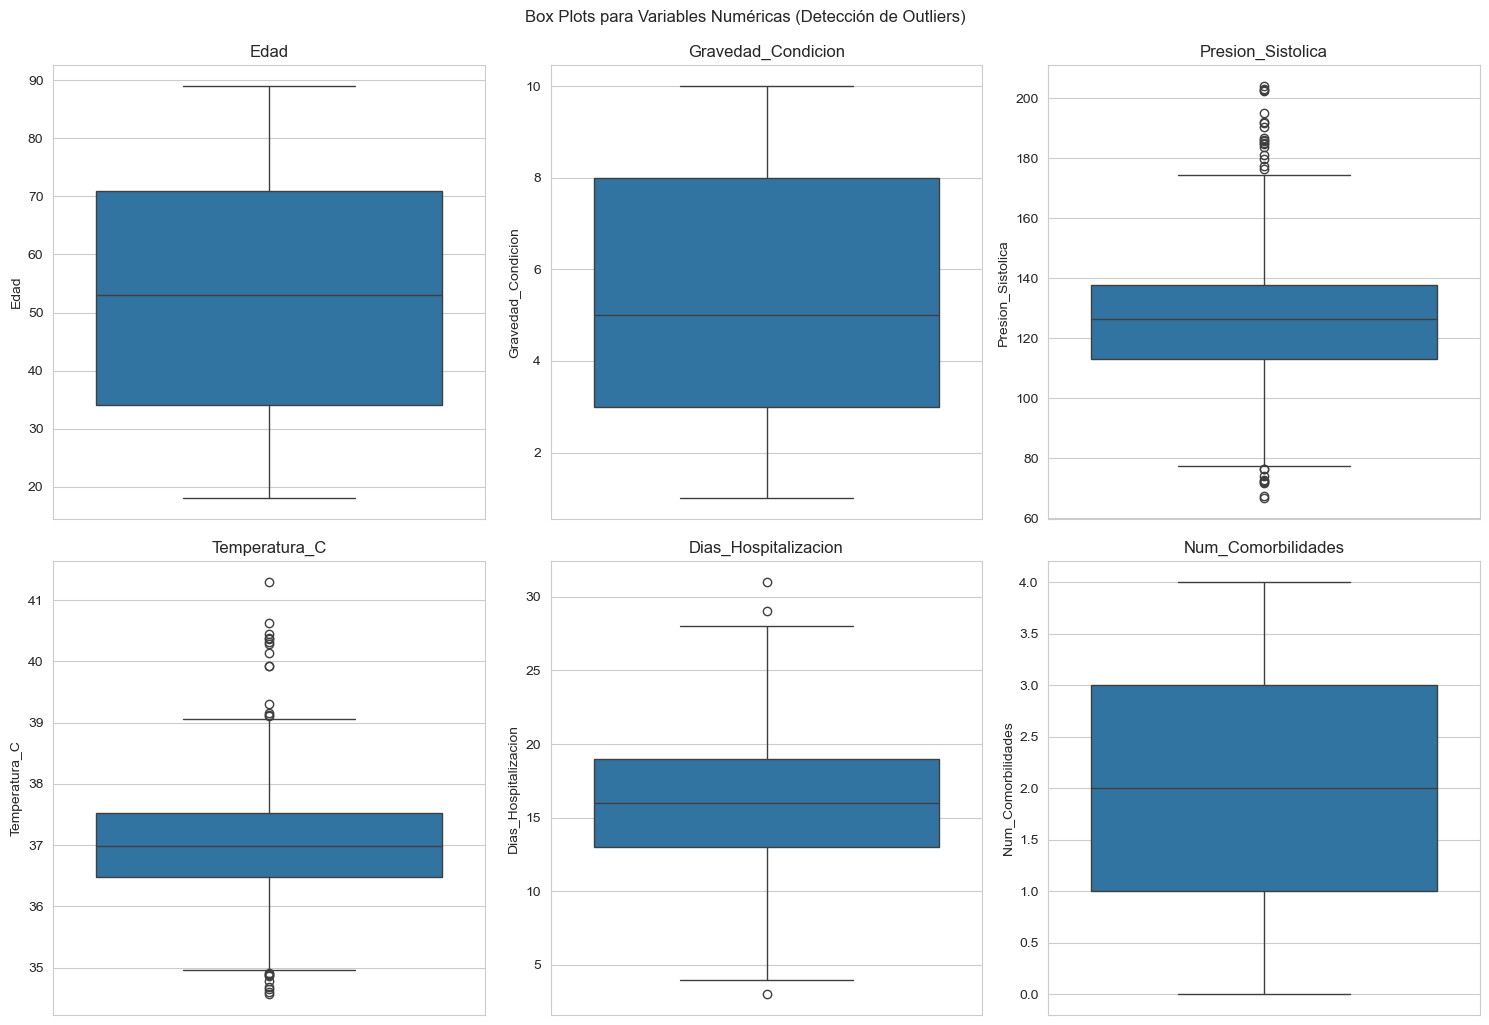


--- 2.4.3 Distribución de Variables Categóricas (Count Plots) ---


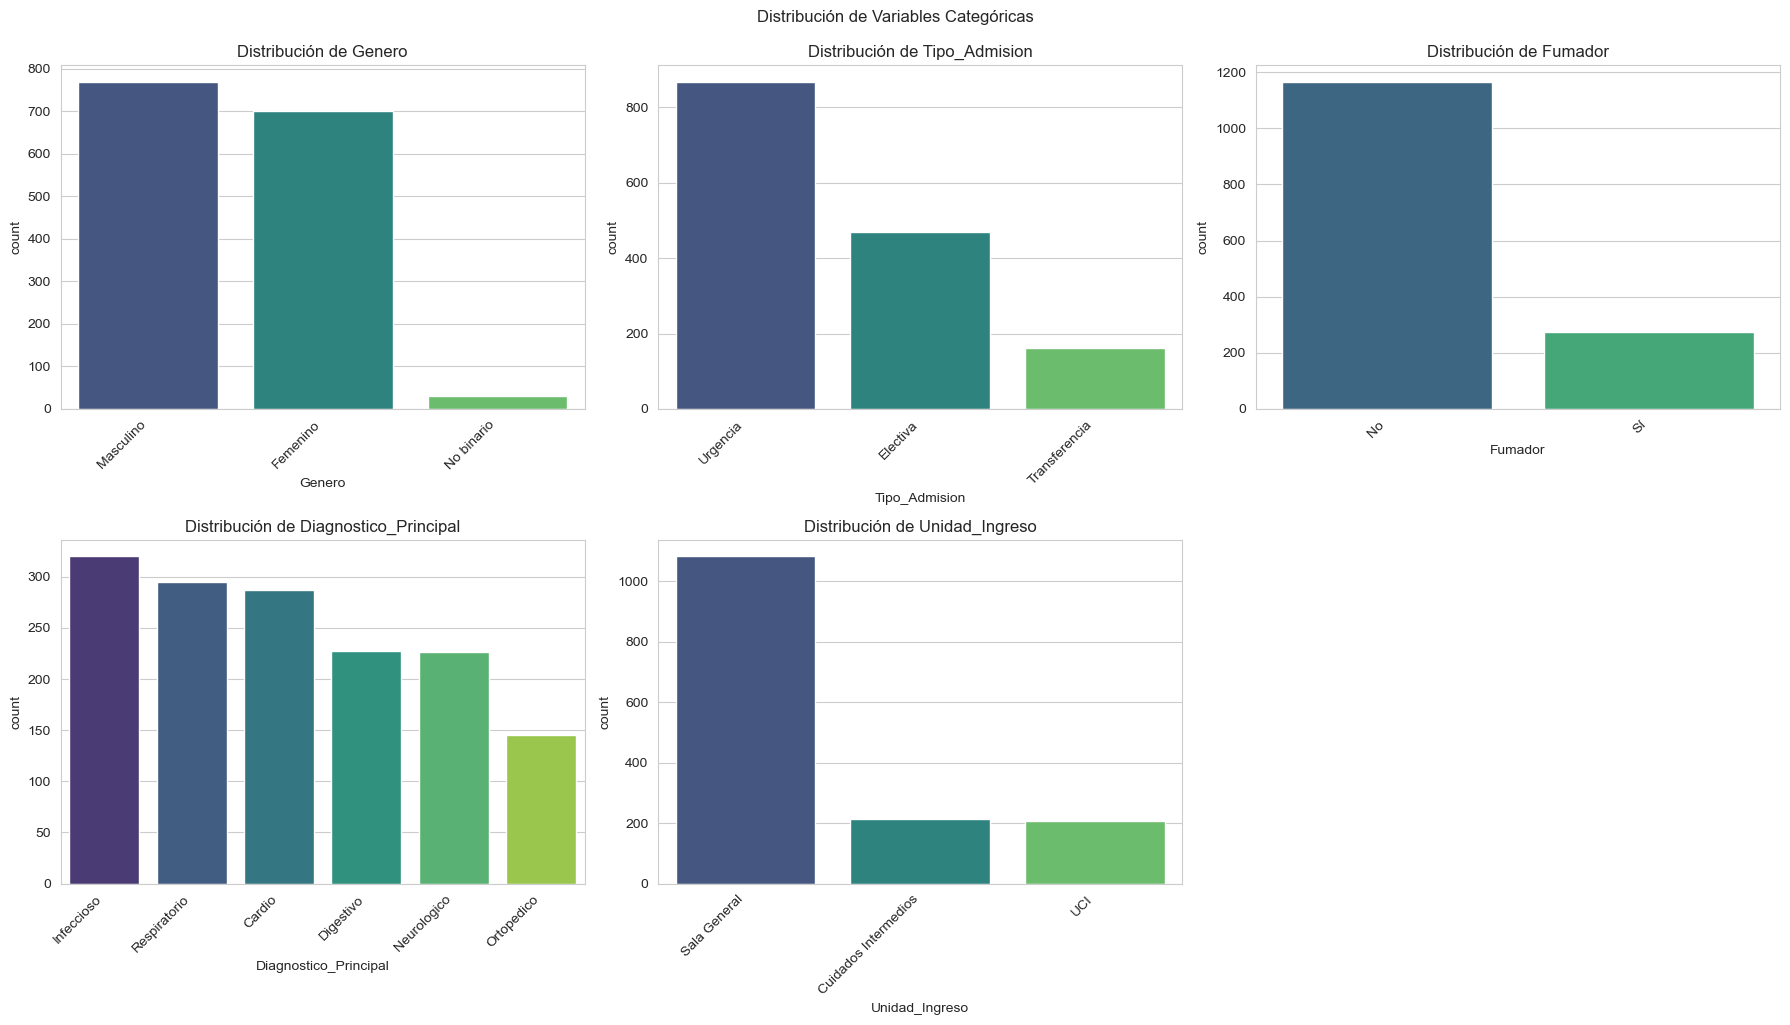


--- 2.4.4 Relación de Variables Clave con Dias_Hospitalizacion (Scatter Plots, Box Plots) ---


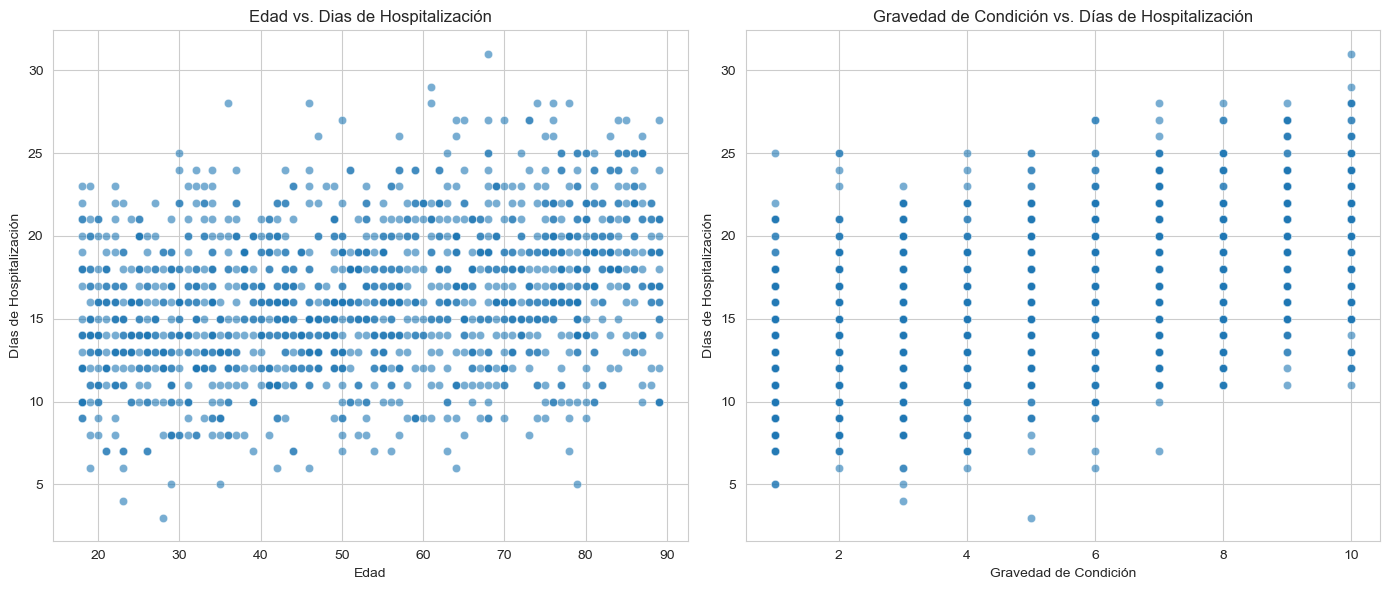

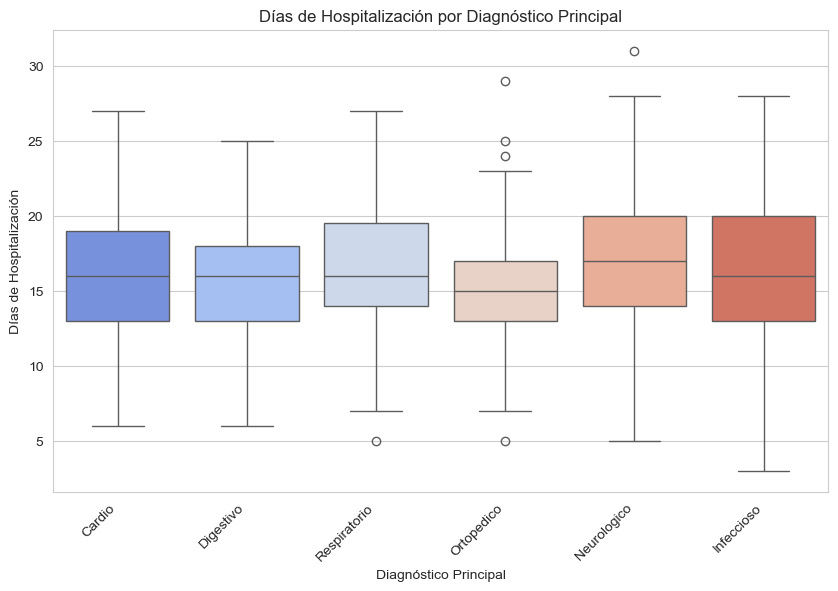

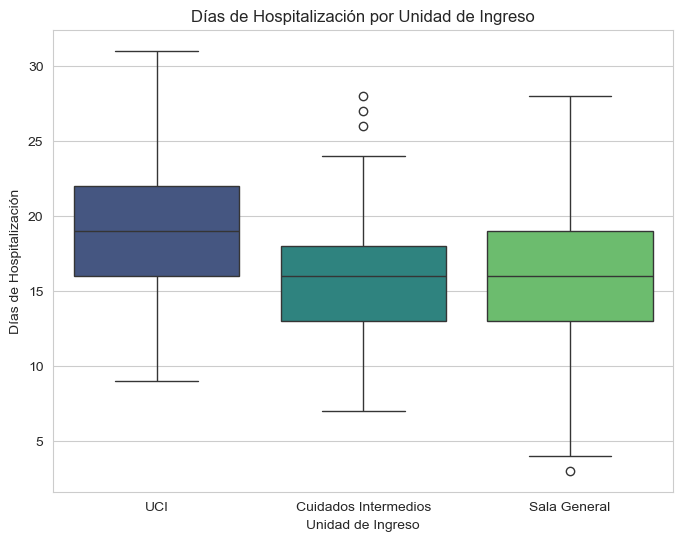


--- 2.4.5 Matriz de Correlación entre Variables Numéricas ---


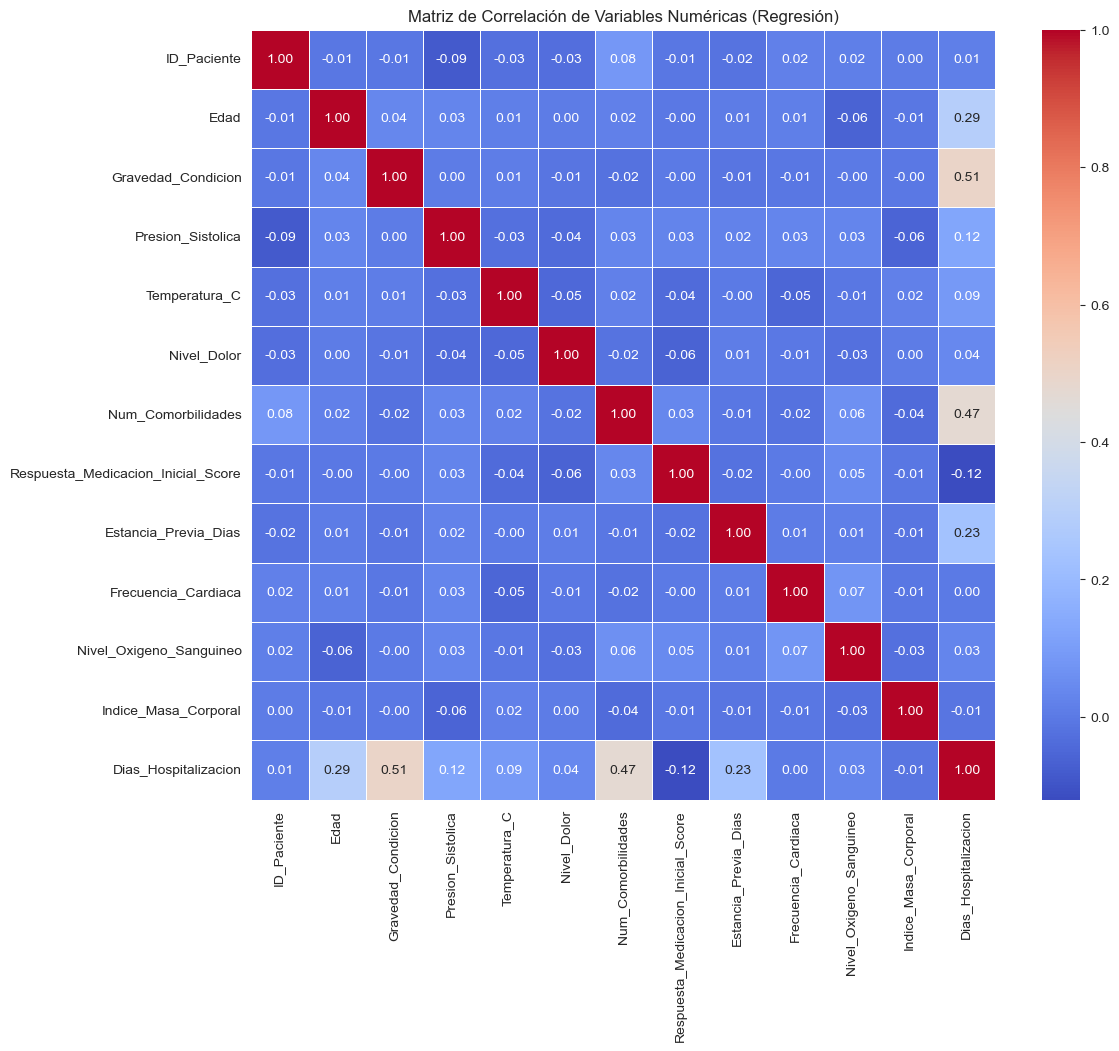


EDA para el problema de regresión completado. Hemos comprendido la estructura y las distribuciones de los datos, y su relación con la variable objetivo.


In [3]:
# %% [markdown]
# ### 2. Exploración Inicial del Dataset (EDA) para Regresión
#
# Realizamos un EDA para comprender la estructura del dataset, la distribución de variables y la presencia de nulos y outliers, con especial atención a la variable objetivo `Dias_Hospitalizacion`.
#

# %%
print("\n--- 2.1 Información General del Dataset de Regresión ---")
print(data_reg.info())

print("\n--- 2.2 Estadísticas Descriptivas de Variables Numéricas (incluyendo objetivo) ---")
print(data_reg.describe())

print("\n--- 2.3 Conteo de Valores para Variables Categóricas ---")
for col in ['Genero', 'Tipo_Admision', 'Tipo_Seguro', 'Fumador', 'Diagnostico_Principal', 'Unidad_Ingreso']:
    if col in data_reg.columns:
        print(f"\nDistribución de '{col}':")
        print(data_reg[col].value_counts(dropna=False))


# %% [markdown]
# ### 2.4 Visualizaciones Clave para Regresión
#
# Las visualizaciones nos permiten entender las distribuciones y las relaciones de manera gráfica, incluyendo la relación con nuestra variable objetivo continua.

# %%
print("\n--- 2.4.1 Histograma de Variables Numéricas Clave y la Variable Objetivo ---")
numeric_cols_for_hist_reg = ['Edad', 'Gravedad_Condicion', 'Presion_Sistolica', 'Temperatura_C', 'Dias_Hospitalizacion', 'Num_Comorbilidades', 'Indice_Masa_Corporal']
data_reg[numeric_cols_for_hist_reg].hist(bins=30, figsize=(18, 12), edgecolor='black')
plt.suptitle('Histogramas de Variables Numéricas y Días de Hospitalización', y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

print("\n--- 2.4.2 Diagramas de Caja (Box Plots) para Identificar Outliers ---")
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_cols_for_hist_reg[:-1]): # Excluimos Dias_Hospitalizacion para boxplot de outliers
    plt.subplot(2, 3, i + 1)
    sns.boxplot(y=data_reg[col].dropna())
    plt.title(col)
plt.tight_layout()
plt.suptitle('Box Plots para Variables Numéricas (Detección de Outliers)', y=1.02)
plt.show()

print("\n--- 2.4.3 Distribución de Variables Categóricas (Count Plots) ---")
categorical_cols_for_plot_reg = ['Genero', 'Tipo_Admision', 'Fumador', 'Diagnostico_Principal', 'Unidad_Ingreso']
plt.figure(figsize=(18, 10))
for i, col in enumerate(categorical_cols_for_plot_reg):
    plt.subplot(2, 3, i + 1)
    sns.countplot(data=data_reg, x=col, palette='viridis', order=data_reg[col].value_counts().index)
    plt.title(f'Distribución de {col}')
    plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.suptitle('Distribución de Variables Categóricas', y=1.02)
plt.show()

print("\n--- 2.4.4 Relación de Variables Clave con Dias_Hospitalizacion (Scatter Plots, Box Plots) ---")

# Scatter plot: Edad vs. Dias_Hospitalizacion
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(data=data_reg, x='Edad', y='Dias_Hospitalizacion', alpha=0.6)
plt.title('Edad vs. Dias de Hospitalización')
plt.xlabel('Edad')
plt.ylabel('Días de Hospitalización')

# Scatter plot: Gravedad_Condicion vs. Dias_Hospitalizacion
plt.subplot(1, 2, 2)
sns.scatterplot(data=data_reg, x='Gravedad_Condicion', y='Dias_Hospitalizacion', alpha=0.6)
plt.title('Gravedad de Condición vs. Días de Hospitalización')
plt.xlabel('Gravedad de Condición')
plt.ylabel('Días de Hospitalización')
plt.tight_layout()
plt.show()

# Box plot: Diagnostico_Principal vs. Dias_Hospitalizacion
plt.figure(figsize=(10, 6))
sns.boxplot(data=data_reg, x='Diagnostico_Principal', y='Dias_Hospitalizacion', palette='coolwarm')
plt.title('Días de Hospitalización por Diagnóstico Principal')
plt.xlabel('Diagnóstico Principal')
plt.ylabel('Días de Hospitalización')
plt.xticks(rotation=45, ha='right')
plt.show()

# Box plot: Unidad_Ingreso vs. Dias_Hospitalizacion
plt.figure(figsize=(8, 6))
sns.boxplot(data=data_reg, x='Unidad_Ingreso', y='Dias_Hospitalizacion', palette='viridis')
plt.title('Días de Hospitalización por Unidad de Ingreso')
plt.xlabel('Unidad de Ingreso')
plt.ylabel('Días de Hospitalización')
plt.xticks(rotation=0)
plt.show()


print("\n--- 2.4.5 Matriz de Correlación entre Variables Numéricas ---")
numeric_data_reg = data_reg.select_dtypes(include=np.number).copy()
correlation_matrix_reg = numeric_data_reg.dropna().corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_reg, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matriz de Correlación de Variables Numéricas (Regresión)')
plt.show()

print("\nEDA para el problema de regresión completado. Hemos comprendido la estructura y las distribuciones de los datos, y su relación con la variable objetivo.")

In [5]:
print("\n--- 3.1 Separación de Datos: Entrenamiento y Prueba ---")
# La variable 'ID_Paciente' no es una característica predictiva, así que la excluimos.
X = data_reg.drop(columns=['ID_Paciente', 'Dias_Hospitalizacion'])
y = data_reg['Dias_Hospitalizacion']

# Dividir el dataset en conjuntos de entrenamiento y prueba
# Para regresión, no usamos 'stratify'.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Dimensiones de X_train: {X_train.shape}")
print(f"Dimensiones de X_test: {X_test.shape}")
print(f"Primeras 5 filas de y_train:\n{y_train.head()}")
print(f"Primeras 5 filas de y_test:\n{y_test.head()}")


print("\n--- 3.2 Ingeniería de Características de Fecha (Antes del Pipeline Principal) ---")

# Calculamos la antigüedad desde el ingreso hasta una fecha de referencia (ej. hoy)
# Usaremos una fecha de referencia posterior a todas las fechas de ingreso
current_date_ref_reg = pd.to_datetime('2025-06-15') # Fecha actual o una posterior a todos los ingresos

# Aplicar a los conjuntos de entrenamiento y prueba
X_train['Dias_Desde_Ingreso'] = (current_date_ref_reg - X_train['Fecha_Ingreso']).dt.days
X_test['Dias_Desde_Ingreso'] = (current_date_ref_reg - X_test['Fecha_Ingreso']).dt.days

# También extraemos características cíclicas como mes, día de la semana, día del año
X_train['Mes_Ingreso'] = X_train['Fecha_Ingreso'].dt.month
X_test['Mes_Ingreso'] = X_test['Fecha_Ingreso'].dt.month

X_train['Dia_Semana_Ingreso'] = X_train['Fecha_Ingreso'].dt.dayofweek # Lunes=0, Domingo=6
X_test['Dia_Semana_Ingreso'] = X_test['Fecha_Ingreso'].dt.dayofweek

X_train['Dia_del_Anio_Ingreso'] = X_train['Fecha_Ingreso'].dt.dayofyear
X_test['Dia_del_Anio_Ingreso'] = X_test['Fecha_Ingreso'].dt.dayofyear

# Una vez extraídas, podemos eliminar la columna original de fecha
X_train = X_train.drop(columns=['Fecha_Ingreso'])
X_test = X_test.drop(columns=['Fecha_Ingreso'])

print("Características de fecha extraídas y columna original eliminada.")
print(f"Columnas de X_train después de FE de fecha: {X_train.columns.tolist()}")


print("\n--- 3.3 Definición del Pipeline de Preprocesamiento (`ColumnTransformer`) ---")

# Identificar tipos de columnas después de la ingeniería de características de fecha
numeric_features = X_train.select_dtypes(include=np.number).columns.tolist()
categorical_features = X_train.select_dtypes(include='object').columns.tolist()

print(f"Características numéricas identificadas: {numeric_features}")
print(f"Características categóricas identificadas: {categorical_features}")

# Pipeline para características numéricas: imputación con la mediana y escalado estándar
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Pipeline para características categóricas: imputación con la moda y OneHotEncoder
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combinar preprocesadores usando ColumnTransformer
preprocessor_reg = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop' # Descarta cualquier columna no especificada
)

print("Preprocesador (ColumnTransformer) configurado para regresión.")
print("\nEl pipeline de preprocesamiento está listo para ser integrado en los modelos de regresión.")


--- 3.1 Separación de Datos: Entrenamiento y Prueba ---
Dimensiones de X_train: (1200, 18)
Dimensiones de X_test: (300, 18)
Primeras 5 filas de y_train:
382     17
538     11
1493    15
1112    16
324     25
Name: Dias_Hospitalizacion, dtype: int32
Primeras 5 filas de y_test:
1116     9
1368    25
422     16
413     26
451     12
Name: Dias_Hospitalizacion, dtype: int32

--- 3.2 Ingeniería de Características de Fecha (Antes del Pipeline Principal) ---
Características de fecha extraídas y columna original eliminada.
Columnas de X_train después de FE de fecha: ['Edad', 'Gravedad_Condicion', 'Presion_Sistolica', 'Temperatura_C', 'Nivel_Dolor', 'Num_Comorbilidades', 'Respuesta_Medicacion_Inicial_Score', 'Estancia_Previa_Dias', 'Frecuencia_Cardiaca', 'Nivel_Oxigeno_Sanguineo', 'Indice_Masa_Corporal', 'Genero', 'Tipo_Admision', 'Tipo_Seguro', 'Fumador', 'Diagnostico_Principal', 'Unidad_Ingreso', 'Dias_Desde_Ingreso', 'Mes_Ingreso', 'Dia_Semana_Ingreso', 'Dia_del_Anio_Ingreso']

--- 3.3 Defi


--- 4.1 Definición y Entrenamiento de Pipelines de Regresión ---

Entrenando y evaluando: Linear Regression...
--- Resultados para Linear Regression ---
Mean Squared Error (MSE): 4.70
Mean Absolute Error (MAE): 1.75
R-squared (R2): 0.7706
Mean Absolute Percentage Error (MAPE): 11.71%

Entrenando y evaluando: Ridge Regression...
--- Resultados para Ridge Regression ---
Mean Squared Error (MSE): 4.70
Mean Absolute Error (MAE): 1.75
R-squared (R2): 0.7706
Mean Absolute Percentage Error (MAPE): 11.71%

Entrenando y evaluando: Lasso Regression...
--- Resultados para Lasso Regression ---
Mean Squared Error (MSE): 12.06
Mean Absolute Error (MAE): 2.79
R-squared (R2): 0.4111
Mean Absolute Percentage Error (MAPE): 19.07%

Entrenando y evaluando: Decision Tree Regressor...
--- Resultados para Decision Tree Regressor ---
Mean Squared Error (MSE): 12.51
Mean Absolute Error (MAE): 2.87
R-squared (R2): 0.3890
Mean Absolute Percentage Error (MAPE): 18.97%

Entrenando y evaluando: Support Vector Regr

ValueError: keyword ha is not recognized; valid keywords are ['size', 'width', 'color', 'tickdir', 'pad', 'labelsize', 'labelcolor', 'zorder', 'gridOn', 'tick1On', 'tick2On', 'label1On', 'label2On', 'length', 'direction', 'left', 'bottom', 'right', 'top', 'labelleft', 'labelbottom', 'labelright', 'labeltop', 'labelrotation', 'grid_agg_filter', 'grid_alpha', 'grid_animated', 'grid_antialiased', 'grid_clip_box', 'grid_clip_on', 'grid_clip_path', 'grid_color', 'grid_dash_capstyle', 'grid_dash_joinstyle', 'grid_dashes', 'grid_data', 'grid_drawstyle', 'grid_figure', 'grid_fillstyle', 'grid_gapcolor', 'grid_gid', 'grid_in_layout', 'grid_label', 'grid_linestyle', 'grid_linewidth', 'grid_marker', 'grid_markeredgecolor', 'grid_markeredgewidth', 'grid_markerfacecolor', 'grid_markerfacecoloralt', 'grid_markersize', 'grid_markevery', 'grid_mouseover', 'grid_path_effects', 'grid_picker', 'grid_pickradius', 'grid_rasterized', 'grid_sketch_params', 'grid_snap', 'grid_solid_capstyle', 'grid_solid_joinstyle', 'grid_transform', 'grid_url', 'grid_visible', 'grid_xdata', 'grid_ydata', 'grid_zorder', 'grid_aa', 'grid_c', 'grid_ds', 'grid_ls', 'grid_lw', 'grid_mec', 'grid_mew', 'grid_mfc', 'grid_mfcalt', 'grid_ms']

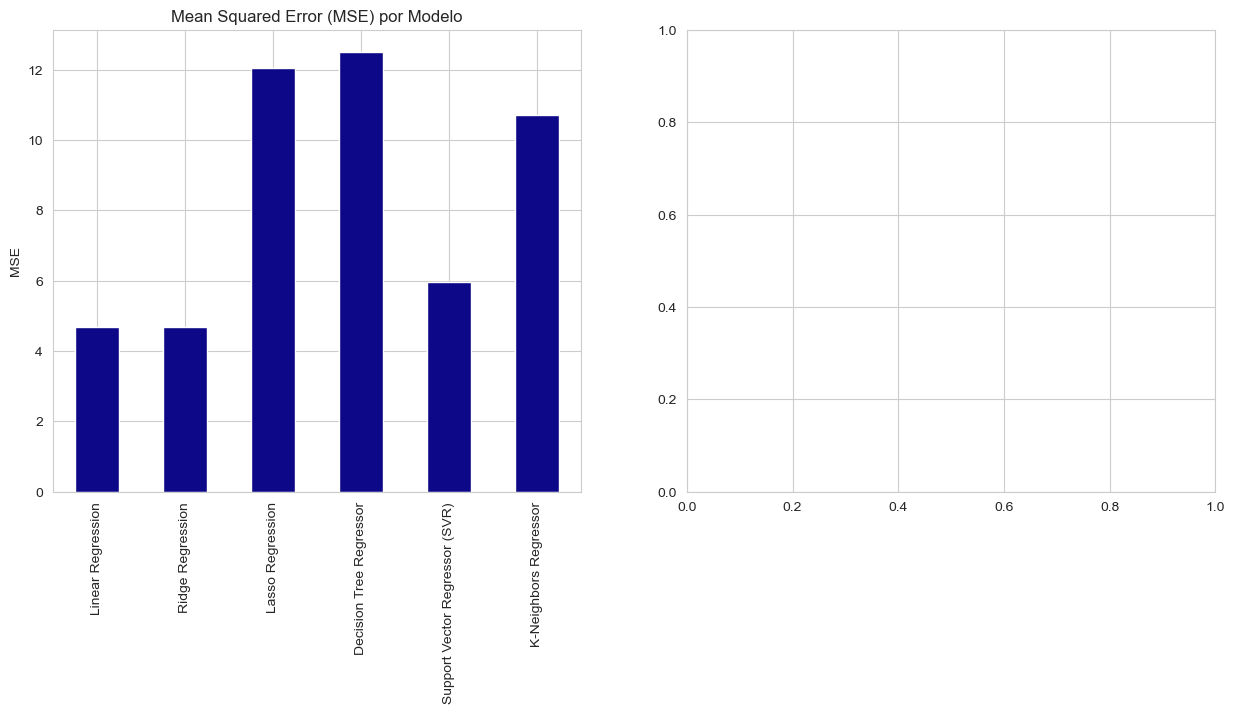

In [7]:
print("\n--- 4.1 Definición y Entrenamiento de Pipelines de Regresión ---")

# Diccionario para almacenar los modelos de regresión y sus pipelines
regression_models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(random_state=42),
    'Lasso Regression': Lasso(random_state=42),
    'Decision Tree Regressor': DecisionTreeRegressor(random_state=42),
    'Support Vector Regressor (SVR)': SVR(), # SVR puede ser lento, se usa sin optimización inicial
    'K-Neighbors Regressor': KNeighborsRegressor()
}

# Diccionario para almacenar los resultados de la evaluación de la regresión
regression_results = {}
# Para almacenar los pipelines entrenados que podrían ser usados más tarde
trained_regression_pipelines = {}

# Iterar sobre cada modelo, construir el pipeline, entrenar y evaluar
for name, model in regression_models.items():
    print(f"\nEntrenando y evaluando: {name}...")

    # Crear el pipeline completo: preprocesador + modelo de regresión
    full_regression_pipeline = Pipeline(steps=[('preprocessor', preprocessor_reg),
                                               ('regressor', model)])

    # Entrenar el pipeline con los datos de entrenamiento
    full_regression_pipeline.fit(X_train, y_train)

    # Realizar predicciones en el conjunto de prueba
    y_pred_reg = full_regression_pipeline.predict(X_test)

    # Evaluar el modelo
    mse = mean_squared_error(y_test, y_pred_reg)
    mae = mean_absolute_error(y_test, y_pred_reg)
    r2 = r2_score(y_test, y_pred_reg)
    
    # MAPE puede generar Inf/NaN si y_test tiene ceros.
    # Dado que Dias_Hospitalizacion siempre es >= 1, MAPE debería ser seguro.
    mape = mean_absolute_percentage_error(y_test, y_pred_reg) * 100 # Multiplicar por 100 para porcentaje

    regression_results[name] = {
        'MSE': mse,
        'MAE': mae,
        'R2': r2,
        'MAPE': mape,
        'Pipeline': full_regression_pipeline # Guardamos el pipeline entrenado
    }
    trained_regression_pipelines[name] = full_regression_pipeline # Guardamos también en un diccionario aparte

    print(f"--- Resultados para {name} ---")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"R-squared (R2): {r2:.4f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")


# %% [markdown]
# ### 4.2 Comparación de Resultados de Regresión y Visualizaciones
#
# Visualicemos las métricas para una comparación más sencilla de los modelos de regresión.

# %%
print("\n--- 4.2 Comparación Visual de Métricas de Modelos de Regresión ---")

# Convertir los resultados a un DataFrame para fácil visualización
regression_results_df = pd.DataFrame.from_dict(regression_results, orient='index')
# Excluimos el pipeline para la visualización de barras
metrics_regression_df = regression_results_df[['MSE', 'MAE', 'R2', 'MAPE']]

print("\nResumen de Métricas de Rendimiento por Modelo de Regresión:")
print(metrics_regression_df)

# Graficar MSE y MAE (menor es mejor)
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

metrics_regression_df[['MSE']].plot(kind='bar', ax=axes[0], colormap='plasma', legend=False)
axes[0].set_title('Mean Squared Error (MSE) por Modelo')
axes[0].set_ylabel('MSE')
axes[0].tick_params(axis='x', rotation=45, ha='right')

metrics_regression_df[['MAE']].plot(kind='bar', ax=axes[1], colormap='viridis', legend=False)
axes[1].set_title('Mean Absolute Error (MAE) por Modelo')
axes[1].set_ylabel('MAE')
axes[1].tick_params(axis='x', rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Graficar R2 (mayor es mejor)
plt.figure(figsize=(10, 6))
metrics_regression_df[['R2']].plot(kind='bar', colormap='cividis', legend=False)
plt.title('R-squared (R2) por Modelo')
plt.ylabel('R2 Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Graficar MAPE (menor es mejor)
plt.figure(figsize=(10, 6))
metrics_regression_df[['MAPE']].plot(kind='bar', colormap='magma', legend=False)
plt.title('Mean Absolute Percentage Error (MAPE) por Modelo')
plt.ylabel('MAPE (%)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# %% [markdown]
# ### 4.3 Análisis de Residuos (Errores de Predicción)
#
# Un análisis crucial en regresión es examinar los residuos (la diferencia entre los valores predichos y los valores reales). Esto nos ayuda a entender si el modelo está haciendo suposiciones correctas o si hay patrones en los errores.
#
# **Para el mejor modelo (basado en R2 o MAE):**
# * **Gráfico de Residuos vs. Predicciones:** Debería mostrar un patrón aleatorio, sin estructuras.
# * **Histograma de Residuos:** Debería ser aproximadamente normal y centrado en cero.
# * **Gráfico de Predicciones vs. Valores Reales:** Los puntos deberían agruparse alrededor de una línea de 45 grados (y=x).

# %%
print("\n--- 4.3 Análisis de Residuos para el Mejor Modelo de Regresión ---")

# Identificar el mejor modelo basado en R2 (mayor R2 es mejor)
best_model_name_reg = metrics_regression_df['R2'].idxmax()
best_regression_pipeline = trained_regression_pipelines[best_model_name_reg]

print(f"El mejor modelo de regresión basado en R2 es: {best_model_name_reg}")

# Realizar predicciones con el mejor modelo en el conjunto de prueba
y_pred_best_reg = best_regression_pipeline.predict(X_test)
residuals = y_test - y_pred_best_reg

# Graficar Residuos vs. Predicciones
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_pred_best_reg, y=residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.title(f'Residuos vs. Predicciones para {best_model_name_reg}')
plt.xlabel('Predicciones (Dias_Hospitalizacion)')
plt.ylabel('Residuos (Actual - Predicción)')

# Histograma de Residuos
plt.subplot(1, 2, 2)
sns.histplot(residuals, kde=True, bins=30)
plt.title(f'Distribución de Residuos para {best_model_name_reg}')
plt.xlabel('Residuos')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()

# Graficar Predicciones vs. Valores Reales
plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_test, y=y_pred_best_reg, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2) # Línea ideal y=x
plt.title(f'Predicciones vs. Valores Reales para {best_model_name_reg}')
plt.xlabel('Valores Reales (Dias_Hospitalizacion)')
plt.ylabel('Valores Predichos (Dias_Hospitalizacion)')
plt.show()

print("\nAnálisis de modelos de regresión completado. Los resultados muestran cómo diferentes algoritmos se desempeñan en la predicción de los días de hospitalización.")


--- 5.1 Revisión de Outliers y Distribuciones (recordatorio para regresión) ---


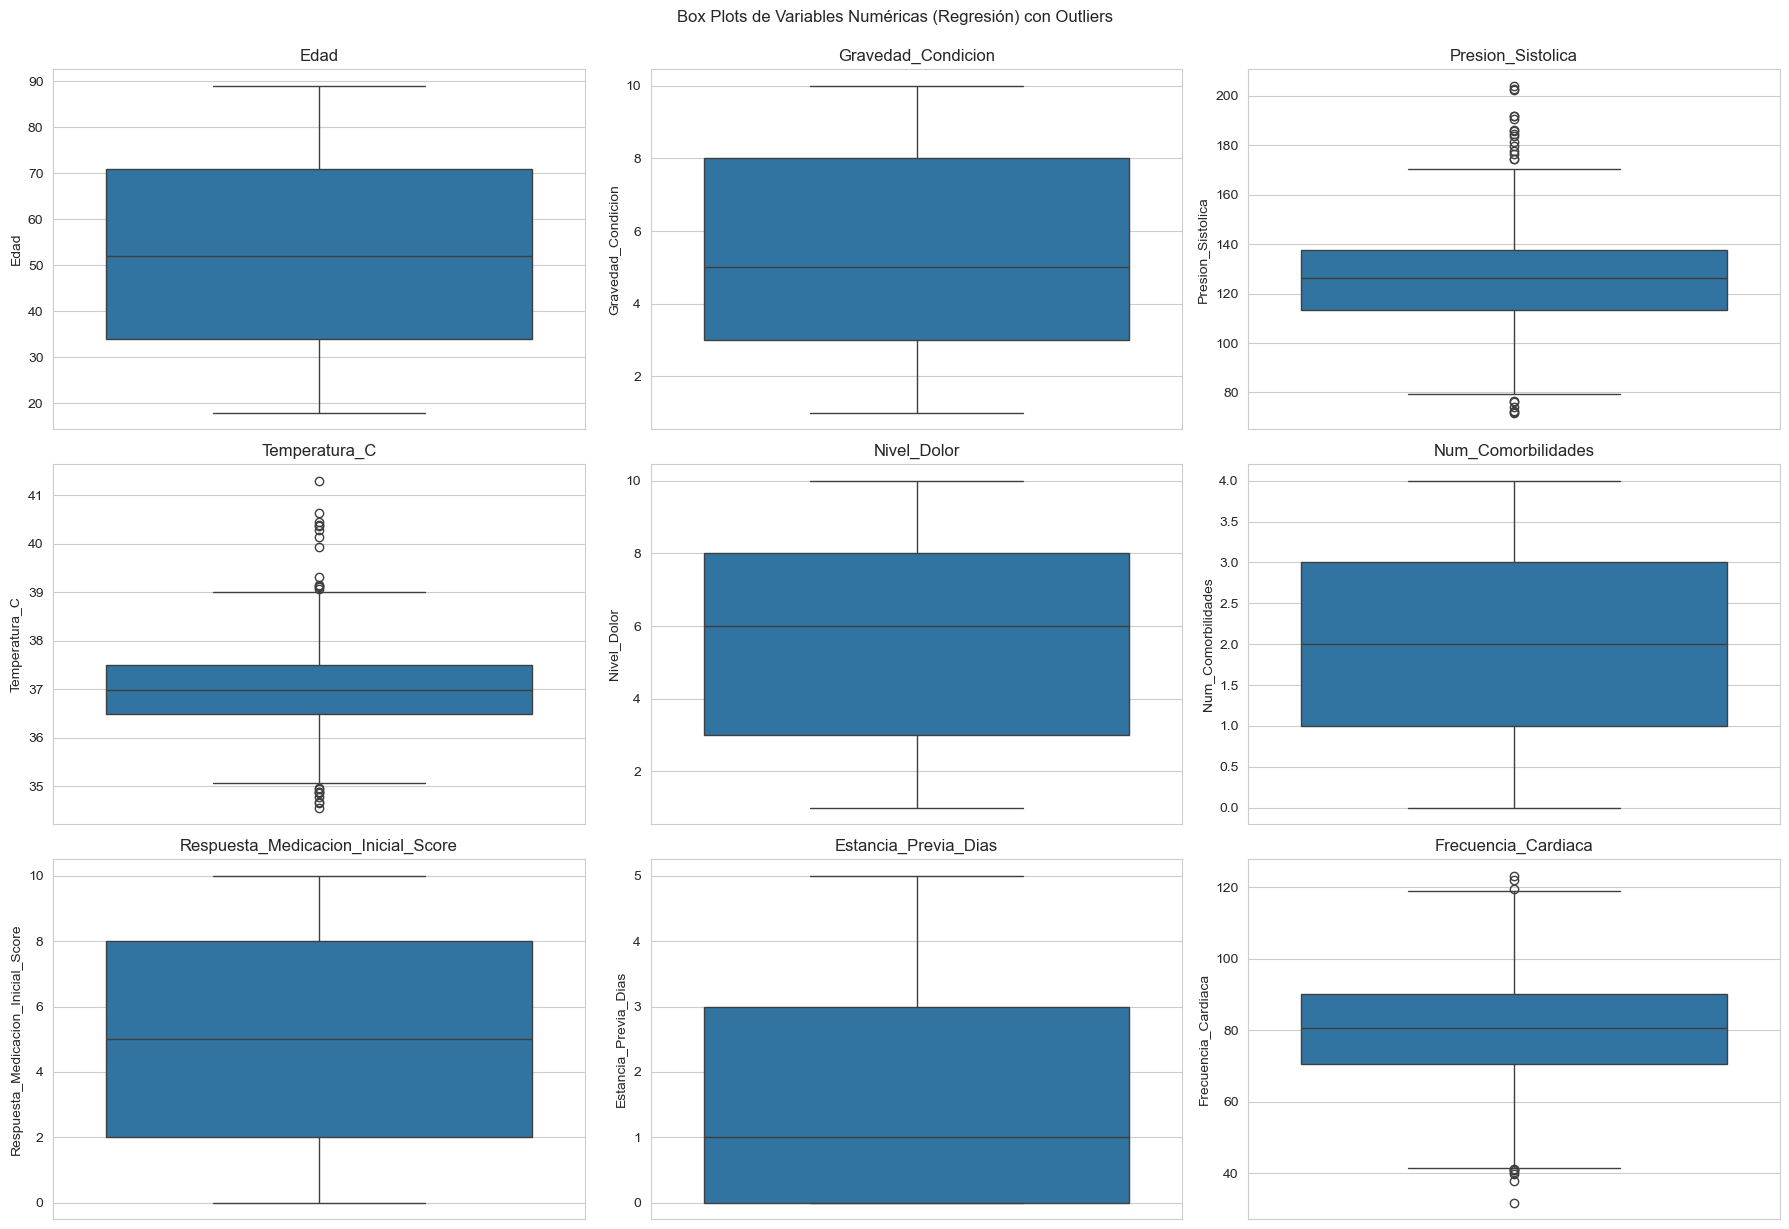

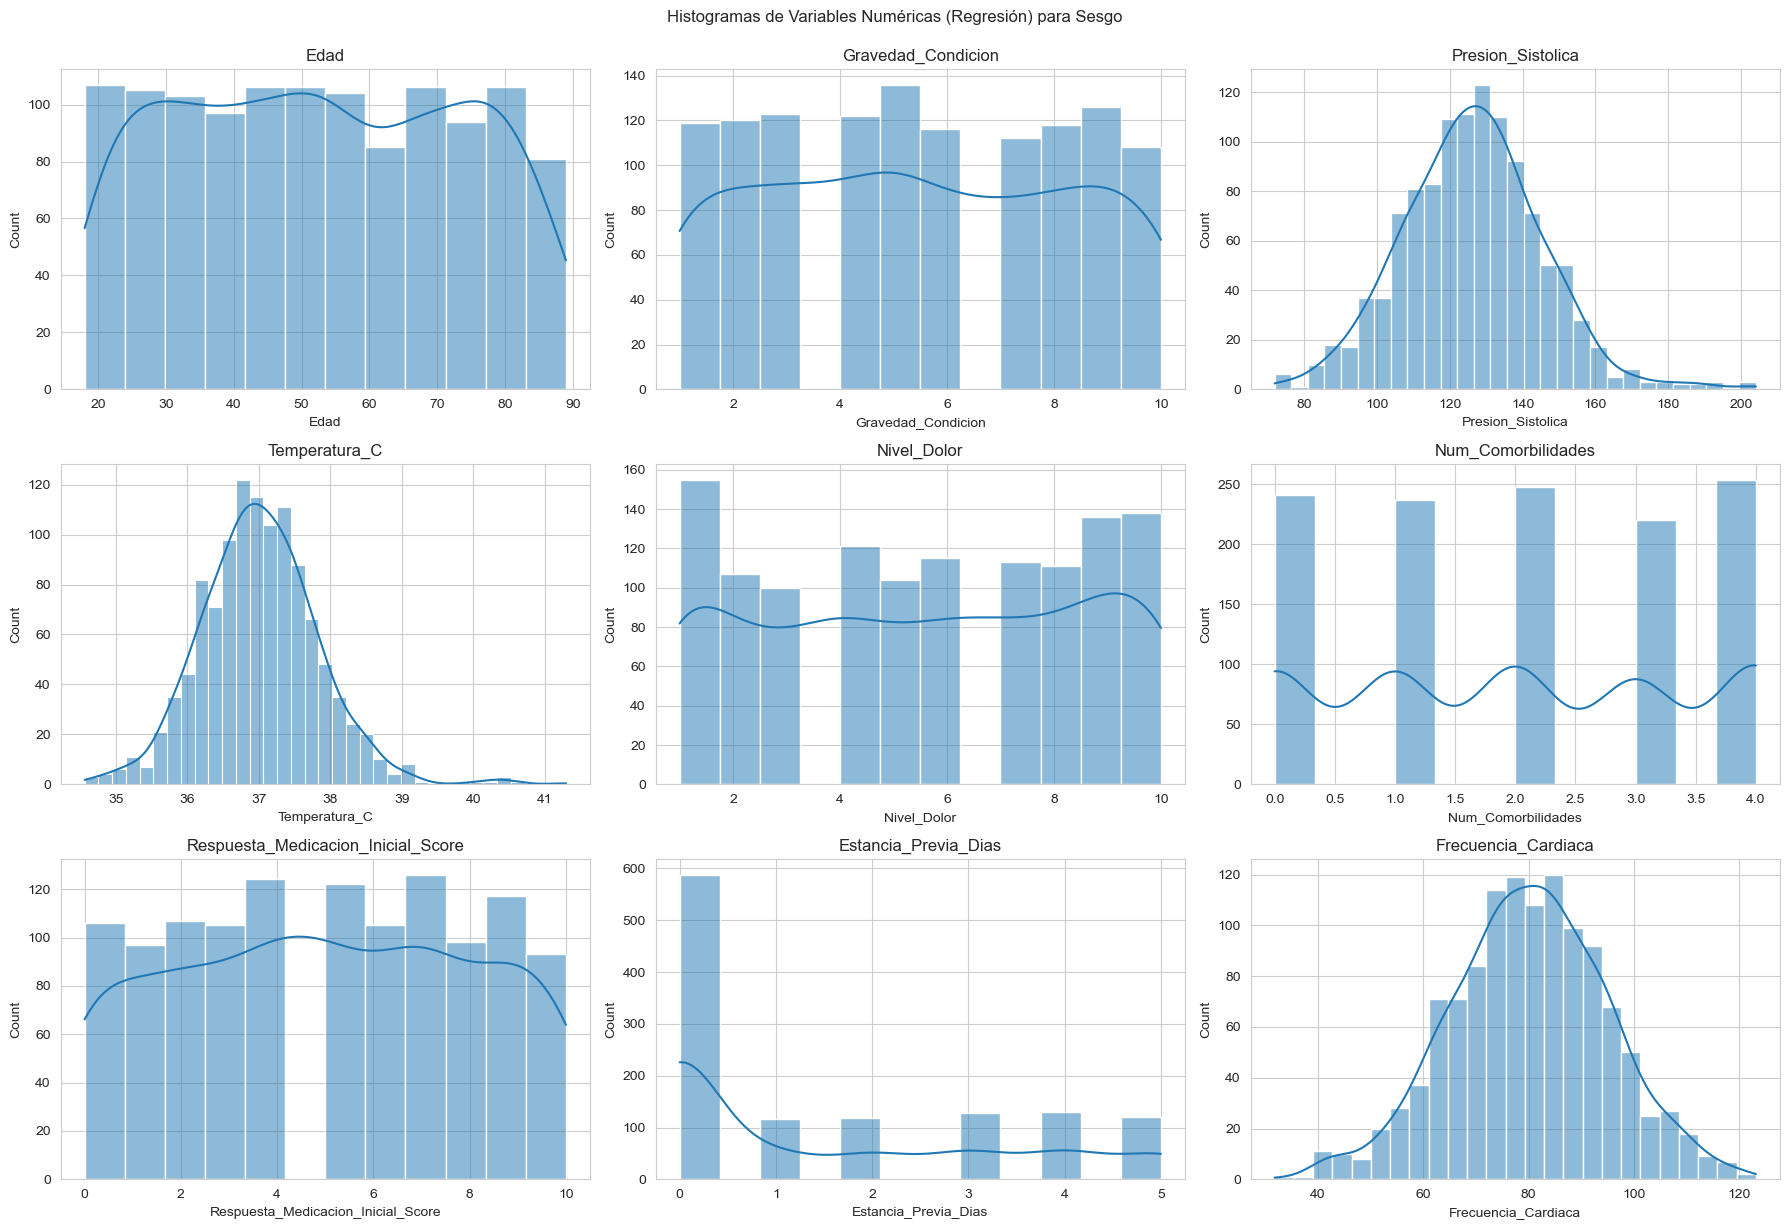


--- 5.2.1 Custom Transformer: OutlierCapper (Reutilizado) ---

--- 5.2.2 Custom Transformer: YeoJohnsonTransformer (Reutilizado) ---

--- 5.2.3 Custom Transformer: CustomDiscretizer (KBinsDiscretizer wrapper, Reutilizado) ---
Custom Transformers (OutlierCapper, YeoJohnsonTransformer, CustomDiscretizer) reutilizados.

--- 5.3 Actualización del Pipeline de Preprocesamiento para Regresión ---
Numéricas para capping de outliers: ['Presion_Sistolica', 'Temperatura_C', 'Frecuencia_Cardiaca', 'Nivel_Oxigeno_Sanguineo', 'Indice_Masa_Corporal']
Numéricas para Yeo-Johnson: ['Edad', 'Estancia_Previa_Dias', 'Dias_Desde_Ingreso']
Numéricas para discretización: ['Nivel_Dolor', 'Respuesta_Medicacion_Inicial_Score', 'Num_Comorbilidades']
Numéricas restantes (solo imputación y escalado): ['Dia_del_Anio_Ingreso', 'Gravedad_Condicion', 'Mes_Ingreso', 'Dia_Semana_Ingreso']
Categóricas: ['Genero', 'Tipo_Admision', 'Tipo_Seguro', 'Fumador', 'Diagnostico_Principal', 'Unidad_Ingreso']
Preprocesador avanzado 

In [9]:
# %% [markdown]
# ### 5. Profundizar en Técnicas Específicas de Feature Engineering (para Regresión)
#
# Reutilizaremos nuestros Custom Transformers (`OutlierCapper`, `YeoJohnsonTransformer`, `CustomDiscretizer`) y los integraremos en un `ColumnTransformer` avanzado para nuestro problema de regresión.
#

# %%
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import PowerTransformer, KBinsDiscretizer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Reconfirmamos la existencia de X_train y X_test
if 'X_train' not in globals() or 'X_test' not in globals():
    print("X_train o X_test no encontrados. Por favor, ejecute los pasos anteriores (1-3) primero.")
    # Si no están, no podemos continuar, se podría salir o lanzar un error.
    # Para la ejecución secuencial, asumimos que están presentes.

print("\n--- 5.1 Revisión de Outliers y Distribuciones (recordatorio para regresión) ---")
# Volvemos a mostrar algunos box plots para recordar la presencia de outliers.
numeric_cols_to_check = [col for col in X_train.select_dtypes(include=np.number).columns if col != 'Dias_Hospitalizacion'] # Excluimos la variable objetivo si por error estuviera aquí
plt.figure(figsize=(18, 12))
for i, col in enumerate(numeric_cols_to_check[:9]): # Mostramos los primeros 9 por espacio
    plt.subplot(3, 3, i + 1)
    sns.boxplot(y=X_train[col].dropna())
    plt.title(col)
plt.tight_layout()
plt.suptitle('Box Plots de Variables Numéricas (Regresión) con Outliers', y=1.02)
plt.show()

# También algunos histogramas para ver la distribución y el sesgo
plt.figure(figsize=(18, 12))
for i, col in enumerate(numeric_cols_to_check[:9]):
    plt.subplot(3, 3, i + 1)
    sns.histplot(X_train[col].dropna(), kde=True)
    plt.title(col)
plt.tight_layout()
plt.suptitle('Histogramas de Variables Numéricas (Regresión) para Sesgo', y=1.02)
plt.show()


# %% [markdown]
# ### 5.2 Reutilización de Operadores a la Medida (Custom Transformers)
#
# Las clases `OutlierCapper`, `YeoJohnsonTransformer` y `CustomDiscretizer` son genéricas y pueden ser reutilizadas directamente. Solo necesitamos asegurarnos de que estén definidas en el entorno actual.

# %%
print("\n--- 5.2.1 Custom Transformer: OutlierCapper (Reutilizado) ---")
class OutlierCapper(BaseEstimator, TransformerMixin):
    """
    Un transformador personalizado para limitar los outliers en columnas numéricas
    utilizando el método IQR (Rango Intercuartílico).
    Los valores por encima de Q3 + 1.5*IQR se limitan a Q3 + 1.5*IQR.
    Los valores por debajo de Q1 - 1.5*IQR se limitan a Q1 - 1.5*IQR.
    """
    def __init__(self, factor=1.5):
        self.factor = factor
        self.upper_bounds_ = {}
        self.lower_bounds_ = {}

    def fit(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        for col in X.columns:
            Q1 = X[col].quantile(0.25)
            Q3 = X[col].quantile(0.75)
            IQR = Q3 - Q1
            self.upper_bounds_[col] = Q3 + (self.factor * IQR)
            self.lower_bounds_[col] = Q1 - (self.factor * IQR)
        return self

    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            # Asumimos que si no es DataFrame, es un array numpy y que las columnas coinciden
            # con las del fit por orden. Esto es un riesgo si ColumnTransformer cambia el orden.
            # Idealmente, ColumnTransformer maneja esto correctamente por índices o nombres.
            # Para mayor robustez, podríamos requerir nombres de columnas o mapear por índice.
            # Aquí, para simplificar, asumimos que ColumnTransformer lo manejará bien.
            X = pd.DataFrame(X, columns=list(self.upper_bounds_.keys())) # Convertir a DataFrame para usar nombres
        X_transformed = X.copy()
        for col in X_transformed.columns:
            if col in self.upper_bounds_ and col in self.lower_bounds_:
                upper = self.upper_bounds_[col]
                lower = self.lower_bounds_[col]
                X_transformed[col] = np.where(X_transformed[col] > upper, upper, X_transformed[col])
                X_transformed[col] = np.where(X_transformed[col] < lower, lower, X_transformed[col])
        return X_transformed


print("\n--- 5.2.2 Custom Transformer: YeoJohnsonTransformer (Reutilizado) ---")
class YeoJohnsonTransformer(BaseEstimator, TransformerMixin):
    """
    Un transformador personalizado para aplicar la transformación Yeo-Johnson
    a columnas numéricas. Maneja valores negativos y cero.
    """
    def __init__(self):
        self.transformer_ = None

    def fit(self, X, y=None):
        self.transformer_ = PowerTransformer(method='yeo-johnson', standardize=False)
        self.transformer_.fit(X)
        return self

    def transform(self, X):
        if self.transformer_ is None:
            raise RuntimeError("Transformer has not been fitted yet. Call fit() first.")
        return self.transformer_.transform(X)


print("\n--- 5.2.3 Custom Transformer: CustomDiscretizer (KBinsDiscretizer wrapper, Reutilizado) ---")
class CustomDiscretizer(BaseEstimator, TransformerMixin):
    """
    Un transformador personalizado para discretizar variables numéricas en bins.
    Envuelve KBinsDiscretizer para integrarlo en nuestro pipeline.
    """
    def __init__(self, n_bins=5, strategy='quantile'):
        self.n_bins = n_bins
        self.strategy = strategy
        self.discretizer_ = None

    def fit(self, X, y=None):
        self.discretizer_ = KBinsDiscretizer(n_bins=self.n_bins, encode='ordinal', strategy=self.strategy, subsample=200_000, random_state=42)
        self.discretizer_.fit(X)
        return self

    def transform(self, X):
        if self.discretizer_ is None:
            raise RuntimeError("Discretizer has not been fitted yet. Call fit() first.")
        return self.discretizer_.transform(X)

print("Custom Transformers (OutlierCapper, YeoJohnsonTransformer, CustomDiscretizer) reutilizados.")


# %% [markdown]
# ### 5.3 Actualización del `ColumnTransformer` con Nuevas Técnicas de Feature Engineering para Regresión
#
# Modificaremos nuestro `preprocessor_reg` para incluir los nuevos transformadores personalizados.
# Seleccionaremos qué variables aplicar cada transformación basándonos en la EDA previa.
#
# * **Manejo de Outliers:** Aplicaremos `OutlierCapper` a `Presion_Sistolica`, `Temperatura_C`, `Frecuencia_Cardiaca`, `Nivel_Oxigeno_Sanguineo`, `Indice_Masa_Corporal`.
# * **Transformación de Variables (Yeo-Johnson):** Aplicaremos `YeoJohnsonTransformer` a `Edad`, `Estancia_Previa_Dias`, `Dias_Desde_Ingreso` (variables que a menudo tienen distribuciones sesgadas y para las que la normalización puede ayudar a los modelos lineales).
# * **Discretización:** Aplicaremos `CustomDiscretizer` a `Nivel_Dolor`, `Respuesta_Medicacion_Inicial_Score`, `Num_Comorbilidades` (para capturar rangos específicos o umbrales importantes).

# %%
print("\n--- 5.3 Actualización del Pipeline de Preprocesamiento para Regresión ---")

# Re-identificar tipos de columnas después de la ingeniería de características de fecha (del Paso 3)
numeric_features_original_reg = X_train.select_dtypes(include=np.number).columns.tolist()
categorical_features_reg = X_train.select_dtypes(include='object').columns.tolist()

# Definir subconjuntos de características numéricas para transformaciones específicas
outlier_cap_features_reg = ['Presion_Sistolica', 'Temperatura_C', 'Frecuencia_Cardiaca', 'Nivel_Oxigeno_Sanguineo', 'Indice_Masa_Corporal']
yeo_johnson_features_reg = ['Edad', 'Estancia_Previa_Dias', 'Dias_Desde_Ingreso']
discretize_features_reg = ['Nivel_Dolor', 'Respuesta_Medicacion_Inicial_Score', 'Num_Comorbilidades']

# Las características restantes numéricas se imputarán y escalarán normalmente
remaining_numeric_features_reg = list(
    set(numeric_features_original_reg)
    - set(outlier_cap_features_reg)
    - set(yeo_johnson_features_reg)
    - set(discretize_features_reg)
)

print(f"Numéricas para capping de outliers: {outlier_cap_features_reg}")
print(f"Numéricas para Yeo-Johnson: {yeo_johnson_features_reg}")
print(f"Numéricas para discretización: {discretize_features_reg}")
print(f"Numéricas restantes (solo imputación y escalado): {remaining_numeric_features_reg}")
print(f"Categóricas: {categorical_features_reg}")


# Nuevo preprocessor con los transformadores personalizados para regresión
preprocessor_advanced_reg = ColumnTransformer(
    transformers=[
        # 1. Pipeline para manejo de nulos y escalado estándar (para la mayoría de numéricas)
        ('num_standard', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), remaining_numeric_features_reg),

        # 2. Pipeline para capping de outliers, imputación y escalado
        ('num_outlier_capped', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('capper', OutlierCapper(factor=1.5)), # Ajustar factor si es necesario
            ('scaler', StandardScaler())
        ]), outlier_cap_features_reg),

        # 3. Pipeline para transformación Yeo-Johnson, imputación y escalado
        ('num_yeo_johnson', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('yj_transform', YeoJohnsonTransformer()),
            ('scaler', StandardScaler()) # Escalar después de la transformación
        ]), yeo_johnson_features_reg),

        # 4. Pipeline para discretización, imputación (si es necesario) y OneHotEncoding de los bins
        ('num_discretized', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')), # Imputar antes de discretizar
            ('discretizer', CustomDiscretizer(n_bins=5, strategy='quantile')),
            ('onehot', OneHotEncoder(handle_unknown='ignore')) # Discretizer output es ordinal, OneHot para bins
        ]), discretize_features_reg),

        # 5. Pipeline para categóricas: imputación y OneHotEncoding (sin cambios)
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_features_reg)
    ],
    remainder='drop' # Descarta cualquier columna no especificada
)

print("Preprocesador avanzado (ColumnTransformer) para regresión configurado con manejo de outliers, transformación de variables y discretización.")
print("\nAhora podemos usar 'preprocessor_advanced_reg' en nuestros pipelines de modelos de regresión.")

# Opcional: Probar el preprocesador avanzado en X_train para ver los resultados (puede generar un array numpy grande)
# X_train_transformed_advanced_reg = preprocessor_advanced_reg.fit_transform(X_train)
# print(f"\nDimensiones de X_train transformado con preprocesador avanzado para regresión: {X_train_transformed_advanced_reg.shape}")
# print("Las primeras 5 filas del dataset transformado (solo para inspección, es un array numpy):")
# print(X_train_transformed_advanced_reg[:5, :])

Librerías cargadas para Optimización de Hiperparámetros de Regresión.

--- 6.1 Optimización de Hiperparámetros para Árbol de Decisión para Regresión (GridSearchCV) ---
Iniciando GridSearchCV para Decision Tree Regressor...
Fitting 5 folds for each of 180 candidates, totalling 900 fits
Mejores hiperparámetros para Decision Tree Regressor: {'regressor__max_depth': 5, 'regressor__max_features': 0.8, 'regressor__min_samples_leaf': 4, 'regressor__min_samples_split': 2}
Mejor MAE en validación cruzada (negado) para Decision Tree Regressor: -2.4946
Mejor MAE real (en validación cruzada) para Decision Tree Regressor: 2.4946
Resultados en el conjunto de prueba (Decision Tree Regressor Optimizado):
  MSE: 11.65, MAE: 2.71, R2: 0.4308, MAPE: 18.02%

--- 6.2 Optimización de Hiperparámetros para SVR (RandomizedSearchCV) ---
Iniciando RandomizedSearchCV para SVR...
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Mejores hiperparámetros para SVR: {'regressor__C': 40.483617105804086, 're

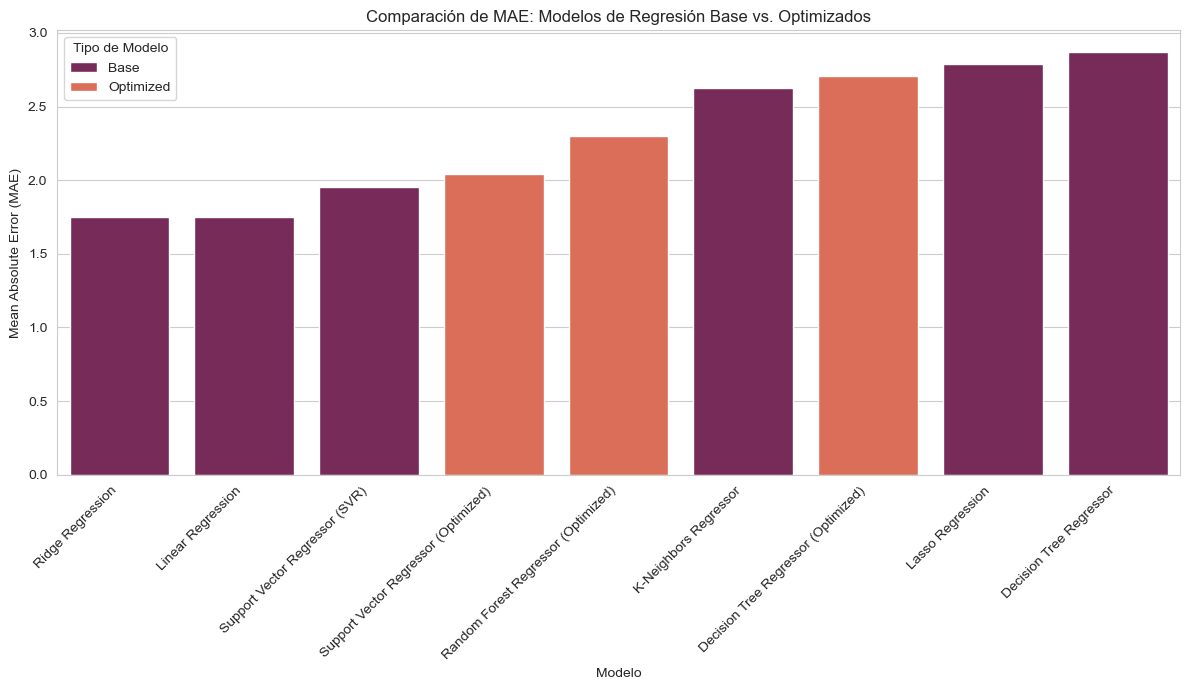

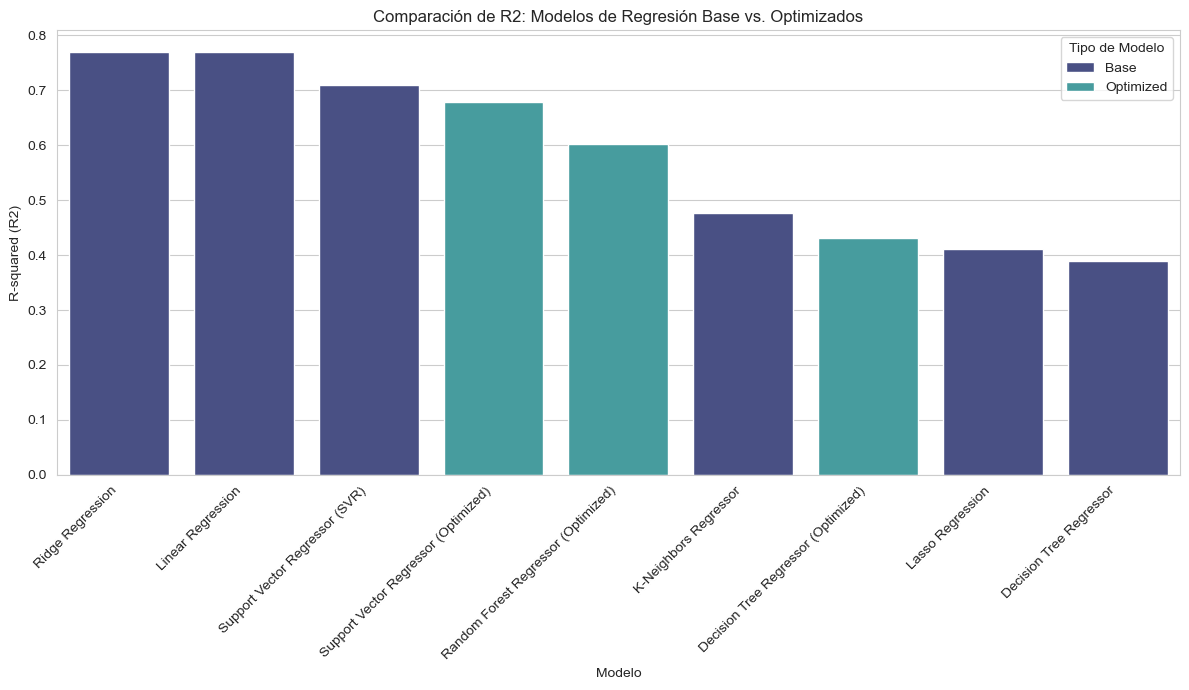


Optimización de hiperparámetros para modelos de regresión completada. Hemos afinado los modelos y cuantificado el impacto de esta optimización.


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer, KBinsDiscretizer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# Modelos de Regresión
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

# Métricas de Regresión
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from scipy.stats import uniform, randint # Para RandomizedSearchCV

import warnings
warnings.filterwarnings('ignore') # Ignorar advertencias

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 100

print("Librerías cargadas para Optimización de Hiperparámetros de Regresión.")

# Asegurarse de que X_train, y_train, X_test, y_test y preprocessor_advanced_reg están disponibles
# (Asume que los pasos 1-5 se han ejecutado en el mismo entorno)
if 'X_train' not in globals() or 'preprocessor_advanced_reg' not in globals():
    print("Variables necesarias (X_train, preprocessor_advanced_reg, etc.) no encontradas. Ejecute los pasos 1-5 primero.")
    # Si no están, no podemos continuar, se podría salir o lanzar un error.

# Diccionario para almacenar los mejores modelos optimizados
best_optimized_regression_models = {}
optimized_regression_results = {}

# --- 6.1 Optimización de Hiperparámetros para Árbol de Decisión para Regresión (GridSearchCV) ---
print("\n--- 6.1 Optimización de Hiperparámetros para Árbol de Decisión para Regresión (GridSearchCV) ---")

# Crear el pipeline base para el Árbol de Decisión
dt_reg_pipeline = Pipeline(steps=[('preprocessor', preprocessor_advanced_reg),
                                  ('regressor', DecisionTreeRegressor(random_state=42))])

# Definir la cuadrícula de hiperparámetros
dt_reg_param_grid = {
    'regressor__max_depth': [None, 5, 10, 15, 20],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4],
    'regressor__max_features': [None, 'sqrt', 'log2', 0.8] # Proporción de características
}

# Configurar GridSearchCV
# scoring='neg_mean_absolute_error' para minimizar MAE
dt_reg_grid_search = GridSearchCV(dt_reg_pipeline, dt_reg_param_grid, cv=5,
                                  scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)

# Ejecutar la búsqueda
print("Iniciando GridSearchCV para Decision Tree Regressor...")
dt_reg_grid_search.fit(X_train, y_train)

print(f"Mejores hiperparámetros para Decision Tree Regressor: {dt_reg_grid_search.best_params_}")
print(f"Mejor MAE en validación cruzada (negado) para Decision Tree Regressor: {dt_reg_grid_search.best_score_:.4f}")
print(f"Mejor MAE real (en validación cruzada) para Decision Tree Regressor: {-dt_reg_grid_search.best_score_:.4f}")

# Evaluar el mejor modelo en el conjunto de prueba
best_dt_reg_model = dt_reg_grid_search.best_estimator_
y_pred_dt_reg_opt = best_dt_reg_model.predict(X_test)

mse_dt_reg_opt = mean_squared_error(y_test, y_pred_dt_reg_opt)
mae_dt_reg_opt = mean_absolute_error(y_test, y_pred_dt_reg_opt)
r2_dt_reg_opt = r2_score(y_test, y_pred_dt_reg_opt)
mape_dt_reg_opt = mean_absolute_percentage_error(y_test, y_pred_dt_reg_opt) * 100

optimized_regression_results['Decision Tree Regressor (Optimized)'] = {
    'MSE': mse_dt_reg_opt, 'MAE': mae_dt_reg_opt, 'R2': r2_dt_reg_opt, 'MAPE': mape_dt_reg_opt,
    'Pipeline': best_dt_reg_model
}
best_optimized_regression_models['Decision Tree Regressor'] = best_dt_reg_model

print(f"Resultados en el conjunto de prueba (Decision Tree Regressor Optimizado):")
print(f"  MSE: {mse_dt_reg_opt:.2f}, MAE: {mae_dt_reg_opt:.2f}, R2: {r2_dt_reg_opt:.4f}, MAPE: {mape_dt_reg_opt:.2f}%")


# --- 6.2 Optimización de Hiperparámetros para SVR (RandomizedSearchCV) ---
print("\n--- 6.2 Optimización de Hiperparámetros para SVR (RandomizedSearchCV) ---")
# SVR puede ser lento, usaremos RandomizedSearchCV con un número limitado de iteraciones.

# Crear el pipeline base para SVR
svr_pipeline = Pipeline(steps=[('preprocessor', preprocessor_advanced_reg),
                               ('regressor', SVR())])

# Definir la distribución de hiperparámetros
svr_param_distributions = {
    'regressor__kernel': ['rbf', 'linear', 'poly'], # Tipos de kernel
    'regressor__C': uniform(loc=0.1, scale=100), # Rango de C (0.1 a 100.1)
    'regressor__gamma': uniform(loc=0.001, scale=0.1), # Rango de gamma (0.001 a 0.101)
    'regressor__epsilon': uniform(loc=0.01, scale=0.5) # Parámetro epsilon en SVR
}

# Configurar RandomizedSearchCV
svr_random_search = RandomizedSearchCV(svr_pipeline, svr_param_distributions, n_iter=50, # Número de combinaciones a probar
                                       cv=3, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1, random_state=42)

# Ejecutar la búsqueda
print("Iniciando RandomizedSearchCV para SVR...")
svr_random_search.fit(X_train, y_train)

print(f"Mejores hiperparámetros para SVR: {svr_random_search.best_params_}")
print(f"Mejor MAE en validación cruzada (negado) para SVR: {svr_random_search.best_score_:.4f}")
print(f"Mejor MAE real (en validación cruzada) para SVR: {-svr_random_search.best_score_:.4f}")

# Evaluar el mejor modelo en el conjunto de prueba
best_svr_model = svr_random_search.best_estimator_
y_pred_svr_opt = best_svr_model.predict(X_test)

mse_svr_opt = mean_squared_error(y_test, y_pred_svr_opt)
mae_svr_opt = mean_absolute_error(y_test, y_pred_svr_opt)
r2_svr_opt = r2_score(y_test, y_pred_svr_opt)
mape_svr_opt = mean_absolute_percentage_error(y_test, y_pred_svr_opt) * 100

optimized_regression_results['Support Vector Regressor (Optimized)'] = {
    'MSE': mse_svr_opt, 'MAE': mae_svr_opt, 'R2': r2_svr_opt, 'MAPE': mape_svr_opt,
    'Pipeline': best_svr_model
}
best_optimized_regression_models['Support Vector Regressor'] = best_svr_model

print(f"Resultados en el conjunto de prueba (SVR Optimizado):")
print(f"  MSE: {mse_svr_opt:.2f}, MAE: {mae_svr_opt:.2f}, R2: {r2_svr_opt:.4f}, MAPE: {mape_svr_opt:.2f}%")


# --- 6.3 Optimización de Hiperparámetros para Random Forest Regressor (RandomizedSearchCV) ---
print("\n--- 6.3 Optimización de Hiperparámetros para Random Forest Regressor (RandomizedSearchCV) ---")

# Crear el pipeline base para Random Forest Regressor
rf_reg_pipeline = Pipeline(steps=[('preprocessor', preprocessor_advanced_reg),
                                  ('regressor', RandomForestRegressor(random_state=42))])

# Definir la distribución de hiperparámetros
rf_reg_param_distributions = {
    'regressor__n_estimators': randint(low=100, high=500),
    'regressor__max_depth': randint(low=5, high=30),
    'regressor__min_samples_split': randint(low=2, high=20),
    'regressor__min_samples_leaf': randint(low=1, high=10),
    'regressor__max_features': ['sqrt', 'log2', None], # 'auto' en versiones antiguas, 'sqrt' en nuevas
    'regressor__bootstrap': [True, False]
}

# Configurar RandomizedSearchCV
rf_reg_random_search = RandomizedSearchCV(rf_reg_pipeline, rf_reg_param_distributions, n_iter=70,
                                          cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1, random_state=42)

# Ejecutar la búsqueda
print("Iniciando RandomizedSearchCV para Random Forest Regressor...")
rf_reg_random_search.fit(X_train, y_train)

print(f"Mejores hiperparámetros para Random Forest Regressor: {rf_reg_random_search.best_params_}")
print(f"Mejor MAE en validación cruzada (negado) para Random Forest Regressor: {rf_reg_random_search.best_score_:.4f}")
print(f"Mejor MAE real (en validación cruzada) para Random Forest Regressor: {-rf_reg_random_search.best_score_:.4f}")

# Evaluar el mejor modelo en el conjunto de prueba
best_rf_reg_model = rf_reg_random_search.best_estimator_
y_pred_rf_reg_opt = best_rf_reg_model.predict(X_test)

mse_rf_reg_opt = mean_squared_error(y_test, y_pred_rf_reg_opt)
mae_rf_reg_opt = mean_absolute_error(y_test, y_pred_rf_reg_opt)
r2_rf_reg_opt = r2_score(y_test, y_pred_rf_reg_opt)
mape_rf_reg_opt = mean_absolute_percentage_error(y_test, y_pred_rf_reg_opt) * 100

optimized_regression_results['Random Forest Regressor (Optimized)'] = {
    'MSE': mse_rf_reg_opt, 'MAE': mae_rf_reg_opt, 'R2': r2_rf_reg_opt, 'MAPE': mape_rf_reg_opt,
    'Pipeline': best_rf_reg_model
}
best_optimized_regression_models['Random Forest Regressor'] = best_rf_reg_model

print(f"Resultados en el conjunto de prueba (Random Forest Regressor Optimizado):")
print(f"  MSE: {mse_rf_reg_opt:.2f}, MAE: {mae_rf_reg_opt:.2f}, R2: {r2_rf_reg_opt:.4f}, MAPE: {mape_rf_reg_opt:.2f}%")


# %% [markdown]
# ### 6.4 Comparación de Modelos de Regresión: Base vs. Optimizados
#
# Es crucial comparar el rendimiento de los modelos optimizados con sus versiones base del Paso 4 para cuantificar el impacto de la optimización de hiperparámetros.

# %%
print("\n--- 6.4 Resumen de Rendimiento: Modelos de Regresión Base vs. Optimizados ---")

# Convertir los resultados base del Paso 4 a un DataFrame para fácil comparación
base_regression_df = pd.DataFrame.from_dict(regression_results, orient='index')
# Solo las métricas, excluyendo el pipeline para esta tabla
base_regression_metrics_df = base_regression_df[['MSE', 'MAE', 'R2', 'MAPE']].copy()
base_regression_metrics_df['Model Type'] = 'Base'
base_regression_metrics_df['Model Name'] = base_regression_metrics_df.index

# Convertir los resultados optimizados a un DataFrame
optimized_regression_df = pd.DataFrame.from_dict(optimized_regression_results, orient='index')
optimized_regression_metrics_df = optimized_regression_df[['MSE', 'MAE', 'R2', 'MAPE']].copy()
optimized_regression_metrics_df['Model Type'] = 'Optimized'
optimized_regression_metrics_df['Model Name'] = optimized_regression_metrics_df.index


# Concatenar ambos DataFrames para la comparación final
comparison_regression_df = pd.concat([base_regression_metrics_df, optimized_regression_metrics_df])
comparison_regression_df_sorted = comparison_regression_df.sort_values(by='MAE', ascending=True) # Ordenar por MAE, menor es mejor

print(comparison_regression_df_sorted.round(4))

# Visualización de MAE para comparación
plt.figure(figsize=(12, 7))
sns.barplot(x='Model Name', y='MAE', hue='Model Type', data=comparison_regression_df_sorted, palette='rocket')
plt.title('Comparación de MAE: Modelos de Regresión Base vs. Optimizados')
plt.ylabel('Mean Absolute Error (MAE)')
plt.xlabel('Modelo')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Tipo de Modelo')
plt.tight_layout()
plt.show()

# Visualización de R2 para comparación
plt.figure(figsize=(12, 7))
sns.barplot(x='Model Name', y='R2', hue='Model Type', data=comparison_regression_df_sorted, palette='mako')
plt.title('Comparación de R2: Modelos de Regresión Base vs. Optimizados')
plt.ylabel('R-squared (R2)')
plt.xlabel('Modelo')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Tipo de Modelo')
plt.tight_layout()
plt.show()


print("\nOptimización de hiperparámetros para modelos de regresión completada. Hemos afinado los modelos y cuantificado el impacto de esta optimización.")

Librerías cargadas para Modelos de Ensemble de Regresión.

--- 7.1 Definición y Entrenamiento de Pipelines con Modelos de Ensemble para Regresión ---

Entrenando y evaluando: AdaBoost Regressor...
--- Resultados para AdaBoost Regressor ---
Mean Squared Error (MSE): 8.42
Mean Absolute Error (MAE): 2.31
R-squared (R2): 0.5885
Mean Absolute Percentage Error (MAPE): 15.55%

Entrenando y evaluando: Gradient Boosting Regressor...
--- Resultados para Gradient Boosting Regressor ---
Mean Squared Error (MSE): 6.99
Mean Absolute Error (MAE): 2.12
R-squared (R2): 0.6587
Mean Absolute Percentage Error (MAPE): 14.29%

Entrenando y evaluando: XGBoost Regressor...
--- Resultados para XGBoost Regressor ---
Mean Squared Error (MSE): 8.87
Mean Absolute Error (MAE): 2.43
R-squared (R2): 0.5666
Mean Absolute Percentage Error (MAPE): 16.20%

--- 7.2 Comparación de Rendimiento de Todos los Modelos de Regresión ---

--- Tabla de Rendimiento Comparativo Final de Regresión (Ordenado por MAE) ---
   Model Type 

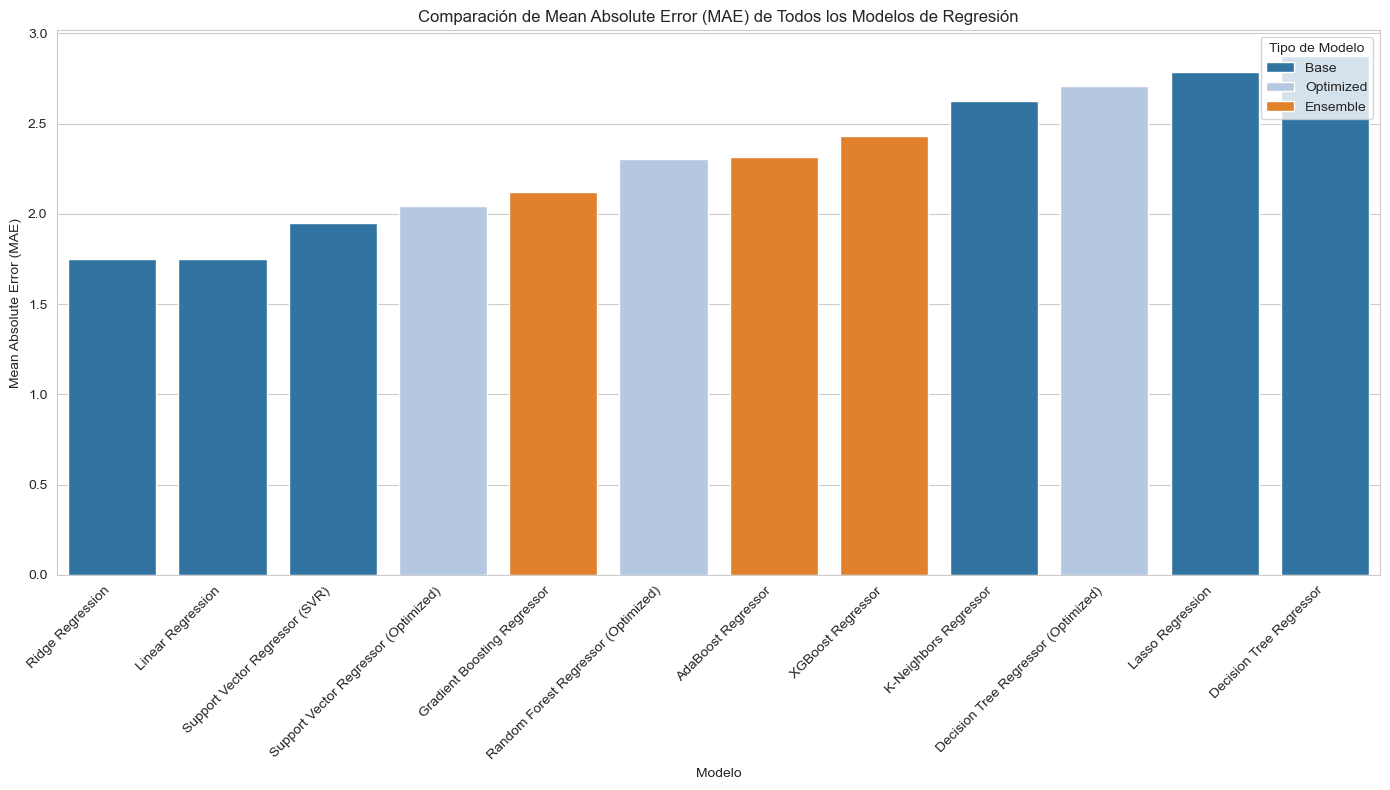

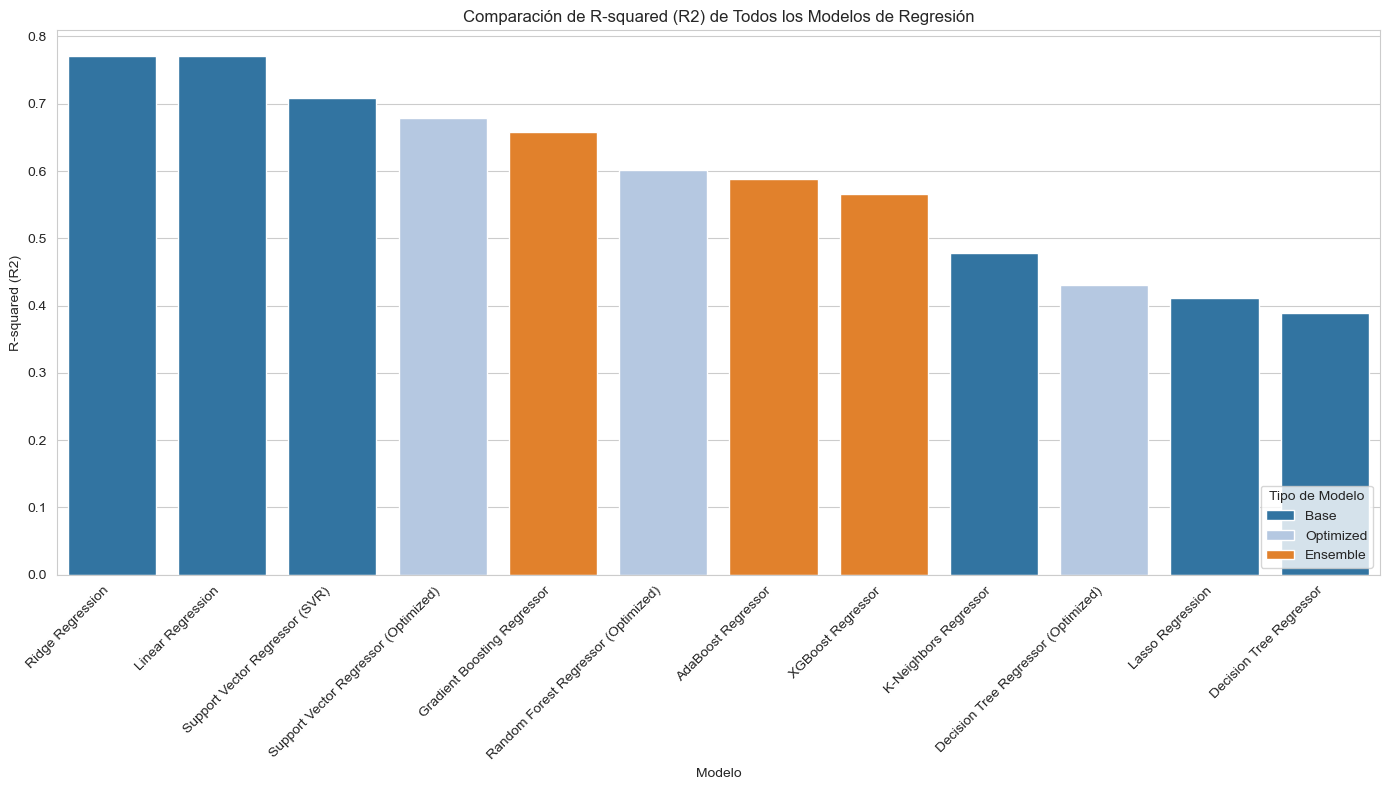

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer, KBinsDiscretizer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# Modelos de Regresión
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor # XGBoost para regresión

# Métricas de Regresión
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
# from scipy.stats import uniform, randint # No se usa directamente en este paso, pero se mantiene si es de un bloque anterior

import warnings
warnings.filterwarnings('ignore') # Ignorar advertencias

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 100

print("Librerías cargadas para Modelos de Ensemble de Regresión.")

# Asegurarse de que X_train, y_train, X_test, y_test y preprocessor_advanced_reg están disponibles
# (Asume que los pasos 1-6 se han ejecutado en el mismo entorno)
if 'X_train' not in globals() or 'preprocessor_advanced_reg' not in globals():
    print("Variables necesarias (X_train, preprocessor_advanced_reg, etc.) no encontradas. Ejecute los pasos 1-6 primero.")
    # Si no están, se podría salir o lanzar un error, o cargar datos de ejemplo.
    # Por brevedad, asumiremos que están disponibles desde celdas anteriores.

# Initialize dictionaries if they don't exist, to prevent NameError
if 'regression_results' not in globals():
    regression_results = {} # Contains results of base models (from Step 4)
    print("Advertencia: 'regression_results' no encontrado. Asegúrese de haber ejecutado el Paso 4.")
if 'optimized_regression_results' not in globals():
    optimized_regression_results = {} # Contains results of optimized models (from Step 6)
    print("Advertencia: 'optimized_regression_results' no encontrado. Asegúrese de haber ejecutado el Paso 6.")
if 'trained_regression_pipelines' not in globals():
    trained_regression_pipelines = {} # Contains pipelines of base models (from Step 4)
    print("Advertencia: 'trained_regression_pipelines' no encontrado. Asegúrese de haber ejecutado el Paso 4.")
if 'best_optimized_regression_models' not in globals():
    best_optimized_regression_models = {} # Contains pipelines of optimized models (from Step 6)
    print("Advertencia: 'best_optimized_regression_models' no encontrado. Asegúrese de haber ejecutado el Paso 6.")


# Diccionario para almacenar los modelos de ensemble y sus pipelines
ensemble_regression_models = {
    'AdaBoost Regressor': AdaBoostRegressor(random_state=42),
    'Gradient Boosting Regressor': GradientBoostingRegressor(random_state=42),
    'XGBoost Regressor': XGBRegressor(use_label_encoder=False, eval_metric='rmse', random_state=42) # eval_metric para regresión
}

# Diccionario para almacenar los resultados de la evaluación de los ensembles
ensemble_regression_results = {}

print("\n--- 7.1 Definición y Entrenamiento de Pipelines con Modelos de Ensemble para Regresión ---")

# Entrenar y evaluar cada modelo de ensemble
for name, model in ensemble_regression_models.items():
    print(f"\nEntrenando y evaluando: {name}...")

    # Crear el pipeline completo: preprocesador avanzado + modelo de regresión
    full_pipeline_ensemble_reg = Pipeline(steps=[('preprocessor', preprocessor_advanced_reg),
                                                 ('regressor', model)])

    # Entrenar el pipeline
    full_pipeline_ensemble_reg.fit(X_train, y_train)

    # Realizar predicciones
    y_pred_ensemble_reg = full_pipeline_ensemble_reg.predict(X_test)

    # Asegurar que las predicciones sean no negativas (días de hospitalización no pueden ser negativos)
    y_pred_ensemble_reg = np.maximum(0, y_pred_ensemble_reg) # O np.maximum(1, ...) si el mínimo es 1 día

    # Evaluar el modelo
    mse = mean_squared_error(y_test, y_pred_ensemble_reg)
    mae = mean_absolute_error(y_test, y_pred_ensemble_reg)
    r2 = r2_score(y_test, y_pred_ensemble_reg)
    mape = mean_absolute_percentage_error(y_test, y_pred_ensemble_reg) * 100

    ensemble_regression_results[name] = {
        'MSE': mse,
        'MAE': mae,
        'R2': r2,
        'MAPE': mape,
        'Pipeline': full_pipeline_ensemble_reg
    }

    print(f"--- Resultados para {name} ---")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"R-squared (R2): {r2:.4f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")


#---

### 7.2 Comparación de Rendimiento de Todos los Modelos de Regresión

#Ahora, consolidaremos y compararemos los resultados de todos los modelos: los base (del paso 4), los optimizados (del paso 6) y los de ensemble (de este paso).

#```python
print("\n--- 7.2 Comparación de Rendimiento de Todos los Modelos de Regresión ---")

final_regression_comparison_rows = []

# Añadir los resultados base (del Paso 4)
for name, res in regression_results.items():
    final_regression_comparison_rows.append({
        'Model Type': 'Base',
        'Model Name': name,
        'MSE': res['MSE'],
        'MAE': res['MAE'],
        'R2': res['R2'],
        'MAPE': res['MAPE']
    })

# Añadir los resultados optimizados (del Paso 6)
for name, res in optimized_regression_results.items():
    final_regression_comparison_rows.append({
        'Model Type': 'Optimized',
        'Model Name': name,
        'MSE': res['MSE'],
        'MAE': res['MAE'],
        'R2': res['R2'],
        'MAPE': res['MAPE']
    })

# Añadir los resultados de ensemble (de este Paso 7)
for name, res in ensemble_regression_results.items():
    final_regression_comparison_rows.append({
        'Model Type': 'Ensemble',
        'Model Name': name,
        'MSE': res['MSE'],
        'MAE': res['MAE'],
        'R2': res['R2'],
        'MAPE': res['MAPE']
    })


final_regression_comparison_df = pd.DataFrame(final_regression_comparison_rows)
# Ordenar por MAE (menor es mejor)
final_regression_comparison_df_sorted = final_regression_comparison_df.sort_values(by='MAE', ascending=True)

print("\n--- Tabla de Rendimiento Comparativo Final de Regresión (Ordenado por MAE) ---")
print(final_regression_comparison_df_sorted.round(4)) # Redondear para mejor visualización

# Visualización del MAE para todos los modelos
plt.figure(figsize=(14, 8))
sns.barplot(x='Model Name', y='MAE', hue='Model Type', data=final_regression_comparison_df_sorted, palette='tab20')
plt.title('Comparación de Mean Absolute Error (MAE) de Todos los Modelos de Regresión')
plt.ylabel('Mean Absolute Error (MAE)')
plt.xlabel('Modelo')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Tipo de Modelo', loc='upper right')
plt.tight_layout()
plt.show()

# Visualización del R2 para todos los modelos
plt.figure(figsize=(14, 8))
sns.barplot(x='Model Name', y='R2', hue='Model Type', data=final_regression_comparison_df_sorted, palette='tab20')
plt.title('Comparación de R-squared (R2) de Todos los Modelos de Regresión')
plt.ylabel('R-squared (R2)')
plt.xlabel('Modelo')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Tipo de Modelo', loc='lower right')
plt.tight_layout()
plt.show()


--- 7.3 Análisis de Residuos para los Mejores Modelos de Ensemble de Regresión ---
El mejor modelo de ensemble basado en MAE es: Gradient Boosting Regressor
El mejor modelo general (considerando base, optimizado, ensemble) es: Ridge Regression


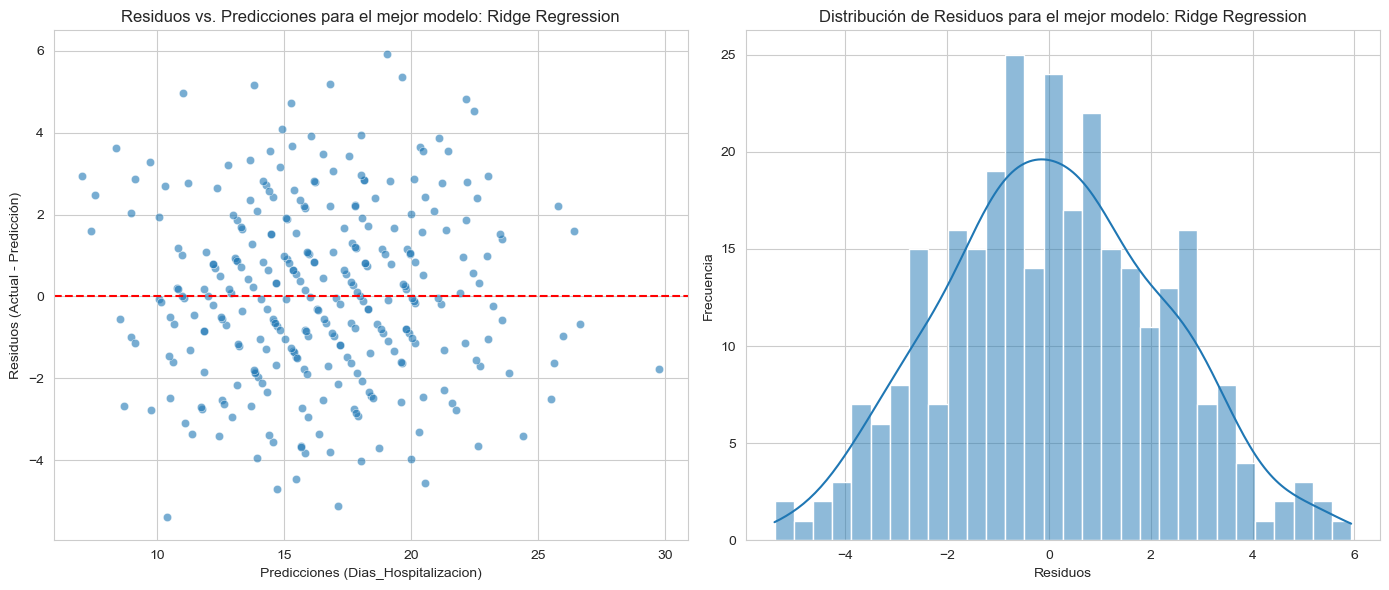

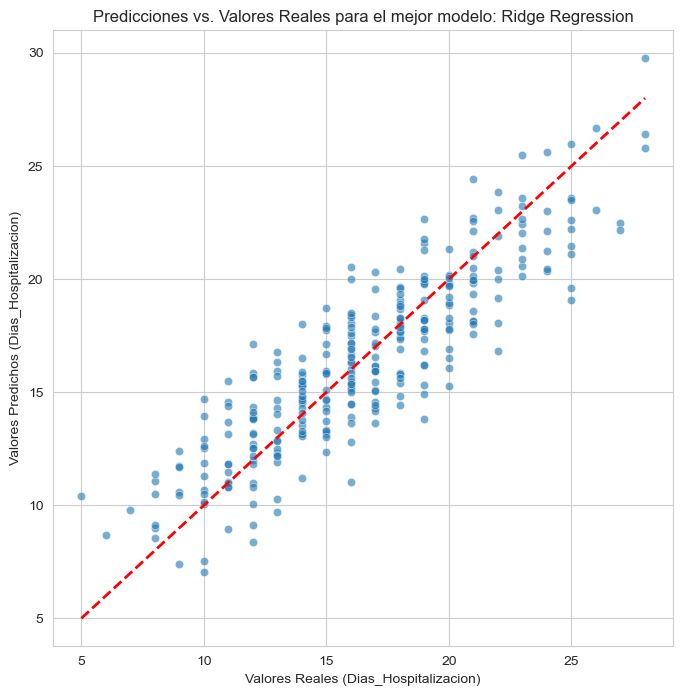


Implementación y comparación de modelos de ensemble para regresión completada.


In [20]:
print("\n--- 7.3 Análisis de Residuos para los Mejores Modelos de Ensemble de Regresión ---")

# La línea problemática era:
# best_ensemble_model_name = ensemble_regression_results['MAE'].idxmin() # Esto no funciona directamente, MAE es una métrica en el diccionario.
# Esa línea ha sido eliminada. La siguiente línea ya hace lo que necesitamos para encontrar el mejor ensemble.

best_ensemble_model_name = final_regression_comparison_df_sorted[
    final_regression_comparison_df_sorted['Model Type'] == 'Ensemble'
].iloc[0]['Model Name']

print(f"El mejor modelo de ensemble basado en MAE es: {best_ensemble_model_name}")

# Recuperar el pipeline del mejor modelo de ensemble
# Consolidar todos los pipelines disponibles (base, optimizados, ensemble) para encontrar el mejor modelo general para la visualización de residuos.
all_pipelines_reg = {}

# Añadir pipelines de modelos base (del Paso 4)
for name, res in regression_results.items():
    if 'Pipeline' in res:
        all_pipelines_reg[name] = res['Pipeline']

# Añadir pipelines de modelos optimizados (del Paso 6)
for name, res in optimized_regression_results.items():
    if 'Pipeline' in res:
        all_pipelines_reg[name] = res['Pipeline']

# Añadir pipelines de modelos de ensemble (de este Paso 7)
for name, res in ensemble_regression_results.items():
    if 'Pipeline' in res:
        all_pipelines_reg[name] = res['Pipeline']


# El mejor modelo general es el primero en el DataFrame ordenado por MAE
best_overall_model_name = final_regression_comparison_df_sorted.iloc[0]['Model Name']

# Check if the best_overall_model_name exists in all_pipelines_reg
if best_overall_model_name in all_pipelines_reg:
    best_overall_pipeline = all_pipelines_reg[best_overall_model_name]
else:
    print(f"Advertencia: El pipeline para el mejor modelo '{best_overall_model_name}' no se encontró en 'all_pipelines_reg'. No se puede realizar el análisis de residuos.")
    # You might want to exit or handle this case appropriately if the pipeline isn't found.
    best_overall_pipeline = None # Set to None to prevent further errors

if best_overall_pipeline: # Only proceed if pipeline was found
    print(f"El mejor modelo general (considerando base, optimizado, ensemble) es: {best_overall_model_name}")

    y_pred_best_overall_reg = best_overall_pipeline.predict(X_test)
    y_pred_best_overall_reg = np.maximum(0, y_pred_best_overall_reg) # Asegurar no negativos

    residuals_overall = y_test - y_pred_best_overall_reg

    # Graficar Residuos vs. Predicciones para el mejor modelo general
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    sns.scatterplot(x=y_pred_best_overall_reg, y=residuals_overall, alpha=0.6)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title(f'Residuos vs. Predicciones para el mejor modelo: {best_overall_model_name}')
    plt.xlabel('Predicciones (Dias_Hospitalizacion)')
    plt.ylabel('Residuos (Actual - Predicción)')

    # Histograma de Residuos para el mejor modelo general
    plt.subplot(1, 2, 2)
    sns.histplot(residuals_overall, kde=True, bins=30)
    plt.title(f'Distribución de Residuos para el mejor modelo: {best_overall_model_name}')
    plt.xlabel('Residuos')
    plt.ylabel('Frecuencia')
    plt.tight_layout()
    plt.show()

    # Graficar Predicciones vs. Valores Reales para el mejor modelo general
    plt.figure(figsize=(8, 8))
    sns.scatterplot(x=y_test, y=y_pred_best_overall_reg, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2) # Línea ideal y=x
    plt.title(f'Predicciones vs. Valores Reales para el mejor modelo: {best_overall_model_name}')
    plt.xlabel('Valores Reales (Dias_Hospitalizacion)')
    plt.ylabel('Valores Predichos (Dias_Hospitalizacion)')
    plt.show()
else:
    print("No se pudo obtener el pipeline del mejor modelo para el análisis de residuos.")


print("\nImplementación y comparación de modelos de ensemble para regresión completada.")